In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Data and Libraries


In [ ]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix as cm
from scipy.sparse import hstack
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time
from sklearn.model_selection import cross_validate 
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.model_selection import cross_validate
from tqdm import tqdm

CPU times: user 75 µs, sys: 0 ns, total: 75 µs
Wall time: 79.9 µs


In [ ]:
mvp_cat = ['Abstract', 'Response to reviewer comments',
       'Research paper_Journal article']

np.random.seed(42)
df = pd.read_csv("/content/drive/MyDrive/PlakshaNLP/capstone/data_json_space_corrected_with_tables_try.csv")
df.loc[df.heading_text.isnull(), "heading_text"] = " "
df = df.loc[(df["text"].notnull())]
df["raw_category"]  = df.doc_category.copy()
df.loc[~df.doc_category.isin(mvp_cat), "doc_category"] = "Other"
df["rtrc"] = df.doc_category.copy()
df.loc[~(df.doc_category == "Response to reviewer comments"), "rtrc"] = "non-rtrc"
df.loc[(df.doc_category == "Response to reviewer comments"), "rtrc"] = "rtrc"
df["abstract"] = df.doc_category.copy()
df.loc[~(df.doc_category == "Abstract"), "abstract"] = "non-abstract"
df.loc[(df.doc_category == "Abstract"), "abstract"] = "abstract"
df["rp"] = df.doc_category.copy()
df.loc[~(df.doc_category == "Research paper_Journal article"), "rp"] = "non-rp"
df.loc[(df.doc_category == "Research paper_Journal article"), "rp"] = "rp"
df["word_count2"] = df.text.str.split(" ").apply(len)
df = df.loc[(df["word_count2"] > 15)].reset_index()

# df_raw = df.loc[~df.index.isin(df.loc[df.doc_category == "Other"].sample(frac=0.87, random_state  =42).index)].reset_index(drop = True)
# df = df.loc[~df.index.isin(df.loc[df.doc_category == "Other"].sample(frac=0.87, random_state  =42).index)].reset_index(drop = True)

df_allcat_train_cv, df_allcat_test = train_test_split(df, test_size = 0.1, random_state =42)
df_allcat_train, df_allcat_val = train_test_split(df_allcat_train_cv, test_size = 0.1111, random_state =42)
df_allcat_train = df_allcat_train.reset_index(drop = True)
df_allcat_train_cv = df_allcat_train_cv.reset_index(drop = True)
df_allcat_val = df_allcat_val.reset_index(drop = True)
df_allcat_test = df_allcat_test.reset_index(drop = True)

full_gold = pd.read_csv("/content/drive/MyDrive/PlakshaNLP/capstone/gold_json_final_with_tables.csv")
full_gold.loc[full_gold.heading_text.isnull(), "heading_text"] = " "
full_gold["raw_category"]  = full_gold.doc_category.copy()
full_gold.loc[~full_gold.doc_category.isin(mvp_cat), "doc_category"] = "Other"
full_gold = full_gold.loc[(full_gold["text"].notnull())]
full_gold["word_count2"] = full_gold.text.str.split(" ").apply(len)
full_gold.doc_category.unique()

array(['Other', 'Abstract', 'Response to reviewer comments',
       'Research paper_Journal article'], dtype=object)

In [ ]:
full_gold["rtrc"] = full_gold.doc_category
full_gold.loc[(full_gold.doc_category == "Response to reviewer comments"), "rtrc"] = "rtrc"
full_gold.loc[~(full_gold.doc_category == "Response to reviewer comments"), "rtrc"] = "non-rtrc"
full_gold["abstract"] = full_gold.doc_category.copy()
full_gold.loc[(full_gold.doc_category == "Abstract"), "abstract"] = "abstract"
full_gold.loc[~(full_gold.doc_category == "Abstract"), "abstract"] = "non-abstract"
full_gold["rp"] = full_gold.doc_category.copy()
full_gold.loc[(full_gold.doc_category == "Research paper_Journal article"), "rp"] = "rp"
full_gold.loc[~(full_gold.doc_category == "Research paper_Journal article"), "rp"] = "non-rp"
full_gold["domain"] = full_gold["raw_category"]
full_gold["doc_name"] = full_gold["name"].copy()

In [ ]:
df_rtrc_train = df.loc[~df.index.isin(df.loc[df.rtrc == "non-rtrc"].sample(frac=0.75, random_state  =42).index)].reset_index(drop = True)
df_abstract_train = df.loc[~df.index.isin(df.loc[df.abstract == "non-abstract"].sample(frac=0.75, random_state  =42).index)].reset_index(drop = True)
df_rp_train = df.loc[~df.index.isin(df.loc[df.rp == "non-rp"].sample(frac=0.75, random_state  =42).index)].reset_index(drop = True)

In [ ]:
new_gold = pd.read_csv("/content/drive/MyDrive/PlakshaNLP/capstone/new_gold_with_heading_with_no_table_text.csv")
print(new_gold.shape)
new_gold.loc[new_gold.text.isnull(), "text"] = " "
new_gold.loc[new_gold.sam_doc_category == "Others", "sam_doc_category"] = "Other"
new_gold["uneet_rp"] = new_gold.sam_doc_category.copy()
new_gold.loc[~(new_gold.uneet_doc_category == "Research paper_Journal article"), "uneet_rp"] = "non-rp"
new_gold.loc[(new_gold.uneet_doc_category == "Research paper_Journal article"), "uneet_rp"] = "rp"
new_gold["sam_rp"] = new_gold.sam_doc_category.copy()
new_gold.loc[~(new_gold.sam_doc_category == "Research paper_Journal article"), "sam_rp"] = "non-rp"
new_gold.loc[(new_gold.sam_doc_category == "Research paper_Journal article"), "sam_rp"] = "rp"
new_gold["uneet_rtrc"] = new_gold.uneet_doc_category
new_gold.loc[(new_gold.uneet_doc_category == "Response to reviewer comments"), "uneet_rtrc"] = "rtrc"
new_gold.loc[~(new_gold.uneet_doc_category == "Response to reviewer comments"), "uneet_rtrc"] = "non-rtrc"
new_gold["sam_rtrc"] = new_gold.sam_doc_category
new_gold.loc[(new_gold.sam_doc_category == "Response to reviewer comments"), "sam_rtrc"] = "rtrc"
new_gold.loc[~(new_gold.sam_doc_category == "Response to reviewer comments"), "sam_rtrc"] = "non-rtrc"
new_gold["uneet_abstract"] = new_gold.sam_doc_category.copy()
new_gold.loc[(new_gold.uneet_doc_category == "Abstract"), "uneet_abstract"] = "abstract"
new_gold.loc[~(new_gold.uneet_doc_category == "Abstract"), "uneet_abstract"] = "non-abstract"
new_gold["sam_abstract"] = new_gold.sam_doc_category.copy()
new_gold.loc[(new_gold.sam_doc_category == "Abstract"), "sam_abstract"] = "abstract"
new_gold.loc[~(new_gold.sam_doc_category == "Abstract"), "sam_abstract"] = "non-abstract"
new_gold_agree = new_gold.loc[new_gold.uneet_doc_category == new_gold.sam_doc_category].reset_index(drop = True)

(99, 6)


# Load 0 and 1

In [ ]:
results = {}
results_gold  ={}

In [ ]:
mvp_cat = ['Abstract', 'Response to reviewer comments',
       'Research paper_Journal article']

np.random.seed(42)
df = pd.read_csv("/content/drive/MyDrive/PlakshaNLP/capstone/data_json_space_corrected_with_tables.csv")
df.loc[df.heading_text.isnull(), "heading_text"] = " "
df = df.loc[(df["text"].notnull())]
df["raw_category"]  = df.doc_category.copy()
df.loc[~df.doc_category.isin(mvp_cat), "doc_category"] = "Other"
df["rtrc"] = df.doc_category.copy()
df.loc[~(df.doc_category == "Response to reviewer comments"), "rtrc"] = 0
df.loc[(df.doc_category == "Response to reviewer comments"), "rtrc"] = 1
df["abstract"] = df.doc_category.copy()
df.loc[~(df.doc_category == "Abstract"), "abstract"] = 0
df.loc[(df.doc_category == "Abstract"), "abstract"] = 1
df["rp"] = df.doc_category.copy()
df.loc[~(df.doc_category == "Research paper_Journal article"), "rp"] = 0
df.loc[(df.doc_category == "Research paper_Journal article"), "rp"] = 1
df["word_count2"] = df.text.str.split(" ").apply(len)
df = df.loc[(df["word_count2"] > 15)].reset_index()

# df_raw = df.loc[~df.index.isin(df.loc[df.doc_category == "Other"].sample(frac=0.87, random_state  =42).index)].reset_index(drop = True)
# df = df.loc[~df.index.isin(df.loc[df.doc_category == "Other"].sample(frac=0.87, random_state  =42).index)].reset_index(drop = True)

df_allcat_train_cv, df_allcat_test = train_test_split(df, test_size = 0.1, random_state =42)
df_allcat_train, df_allcat_val = train_test_split(df_allcat_train_cv, test_size = 0.1111, random_state =42)
df_allcat_train = df_allcat_train.reset_index(drop = True)
df_allcat_train_cv = df_allcat_train_cv.reset_index(drop = True)
df_allcat_val = df_allcat_val.reset_index(drop = True)
df_allcat_test = df_allcat_test.reset_index(drop = True)

full_gold = pd.read_csv("/content/drive/MyDrive/PlakshaNLP/capstone/gold_json_final_with_tables.csv")
full_gold.loc[full_gold.heading_text.isnull(), "heading_text"] = " "
full_gold["raw_category"]  = full_gold.doc_category.copy()
full_gold.loc[~full_gold.doc_category.isin(mvp_cat), "doc_category"] = "Other"
full_gold = full_gold.loc[(full_gold["text"].notnull())]
full_gold["word_count2"] = full_gold.text.str.split(" ").apply(len)
full_gold.doc_category.unique()

full_gold["rtrc"] = full_gold.doc_category
full_gold.loc[(full_gold.doc_category == "Response to reviewer comments"), "rtrc"] = 1
full_gold.loc[~(full_gold.doc_category == "Response to reviewer comments"), "rtrc"] = 0
full_gold["abstract"] = full_gold.doc_category.copy()
full_gold.loc[(full_gold.doc_category == "Abstract"), "abstract"] = 1
full_gold.loc[~(full_gold.doc_category == "Abstract"), "abstract"] = 0
full_gold["rp"] = full_gold.doc_category.copy()
full_gold.loc[(full_gold.doc_category == "Research paper_Journal article"), "rp"] = 1
full_gold.loc[~(full_gold.doc_category == "Research paper_Journal article"), "rp"] = 0
full_gold["domain"] = full_gold["raw_category"]
full_gold["doc_name"] = full_gold["name"].copy()

# Document Distribution of full and Train Test Split

In [ ]:
df_allcat_train_cv.groupby("doc_category").count()

,index,doc_name,domain,status,word_count,n_tables,n_paragraphs,n_images,n_headings,heading_text,text,raw_category,rtrc,abstract,rp,word_count2
doc_category,,,,,,,,,,,,,,,,
Abstract,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600
Other,661,661,661,661,661,661,661,661,661,661,661,661,661,661,661,661
Research paper_Journal article,667,667,667,667,667,667,667,667,667,667,667,667,667,667,667,667
Response to reviewer comments,497,497,497,497,497,497,497,497,497,497,497,497,497,497,497,497


In [ ]:
df_allcat_test.groupby("doc_category").count()

,index,doc_name,domain,status,word_count,n_tables,n_paragraphs,n_images,n_headings,heading_text,text,raw_category,rtrc,abstract,rp,word_count2
doc_category,,,,,,,,,,,,,,,,
Abstract,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69,69
Other,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76
Research paper_Journal article,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73
Response to reviewer comments,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52


In [ ]:
full_gold.groupby("doc_category").count()

,name,word_count,n_tables,n_paragraphs,n_images,n_headings,heading_text,text,raw_category,word_count2,rtrc,abstract,rp,domain,doc_name
doc_category,,,,,,,,,,,,,,,
Abstract,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
Other,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
Research paper_Journal article,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
Response to reviewer comments,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20


# Benchmark Functions

In [ ]:
def benchmark(**params):
  clf = params["clf"]
  vectorizer = params["vectorizer"]
  X = params["X"]
  title = params["title"]
  model_details = params["model_details"]
  y = params["y"]
  vectorizer.fit(X)
  t1 = time()
  X_vector = vectorizer.transform(X)
  t2 = time()
  cv = cross_validate(clf, X_vector, y, cv = 5, scoring = scoring)
  for keys, value in cv.items():
    cv[keys] = sum(cv[keys])/len(cv[keys])
  cv["title"] = title
  cv["model_details"] = model_details
  cv["vectoriszation_time"] = (t2-t1)/X.shape[0]
  cv["feature_vector_length"]  =X_vector.shape[0]
  return cv
def benchmark_gold(**params):
  clf = params["clf"]
  vectorizer = params["vectorizer"]
  X = params["X"]
  title = params["title"]
  model_details = params["model_details"]
  y = params["y"]
  t1 = time()
  X_vector = vectorizer.transform(X)
  t2 = time()
  cv = cross_validate(clf, X_vector, y, cv = 1, scoring = scoring)
  for keys, value in cv.items():
    cv[keys] = sum(cv[keys])/len(cv[keys])
  cv["title"] = title
  cv["model_details"] = model_details
  cv["vectoriszation_time"] = (t2-t1)/X.shape[0]
  cv["feature_vector_length"]  =X_vector.shape[0]
  return cv

In [ ]:
def abstract_precision(model, X, y):
  return cr(y, model.predict(X), output_dict = True)["Abstract"]["precision"]
def other_precision(model, X, y):
  return cr(y, model.predict(X), output_dict = True)["Other"]["precision"]
def rtrc_precision(model, X, y):
  return cr(y, model.predict(X), output_dict = True)["Response to reviewer comments"]["precision"]
def rp_precision(model, X, y):
  return cr(y, model.predict(X), output_dict = True)["Research paper_Journal article"]["precision"]
def abstract_recall(model, X, y):
  return cr(y, model.predict(X), output_dict = True)["Abstract"]["recall"]
def other_recall(model, X, y):
  return cr(y, model.predict(X), output_dict = True)["Other"]["recall"]
def rtrc_recall(model, X, y):
  return cr(y, model.predict(X), output_dict = True)["Response to reviewer comments"]["recall"]
def rp_recall(model, X, y):
  return cr(y, model.predict(X), output_dict = True)["Research paper_Journal article"]["recall"]
def macro_precision(model, X, y):
  return cr(y, model.predict(X), output_dict = True)["macro avg"]["precision"]
def macro_f1(model, X, y):
  return cr(y, model.predict(X), output_dict = True)["macro avg"]["f1-score"]
def accuracy(model, X, y):
  return cr(y, model.predict(X), output_dict = True)["accuracy"]

scoring = {
    "abstract_precision":abstract_precision,
    "other_precision":other_precision,
    "rtrc_precision":rtrc_precision,
    "rp_precision":rp_precision,
    "abstract_recall": abstract_recall,
    "other_recall":other_recall,
    "rtrc_recall":rtrc_recall,
    "rp_recall":rp_recall,
    "macro_precision":macro_precision,
    "macro_f1": macro_f1,
    "accuracy": accuracy
}

In [ ]:
scoring = {
    "abstract_precision":abstract_precision,
    "other_precision":other_precision,
    "rtrc_precision":rtrc_precision,
    "rp_precision":rp_precision,
    "abstract_recall": abstract_recall,
    "other_recall":other_recall,
    "rtrc_recall":rtrc_recall,
    "rp_recall":rp_recall,
    "macro_precision":macro_precision,
    "macro_f1": macro_f1,
    "accuracy": accuracy
}

In [ ]:
scoring2 = scoring.copy()
scoring2.pop("other_precision")

<function __main__.other_precision>

In [ ]:
def scorer(rfc, X, y):
  y_pred = rfc.predict(X)
  cr_ = cr(y, y_pred, output_dict = True)
  res = {
      "accuracy":cr_["accuracy"],
      "rp_precision":cr_["Research paper_Journal article"]["precision"], 
      "rtrc_precision":cr_["Response to reviewer comments"]["precision"],
      "abstract_precision":cr_["Abstract"]["precision"],
      "rp_recall":cr_['Research paper_Journal article']["recall"],
      "weighted_f1_score":cr_['weighted avg']["f1-score"],
      "precision_weighted":cr_['weighted avg']['precision'],
      "recall_weighted":cr_['weighted avg']['recall']
  }
  return res

In [ ]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def tokenize(text):
    '''
    It takes text, removes stopwords and returns list of stemmed tokens
    '''
    word_tokens = nltk.word_tokenize(text)
    #Removing stopwords
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    stems = []
    for item in filtered_sentence:
        stems.append(PorterStemmer().stem(item))
    return stems

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Experiment 0: Rule Based Models

In [ ]:
#features extracted during EDA using statistical and empirical observations
rtrc_features = "we agree, we appreciate, \
thank you, reviewer, sincerely, apologize, \
comment, appreciate your, mentioned, please".split(",")

journal_features = "discussion, analyses, shows\
conclusion, analysis, references, summary, \
this article, funded, table".split(",")

Average Inference time : 0.0002191373982380346
                                precision    recall  f1-score   support

                      Abstract       0.79      0.93      0.85        69
Research paper_Journal article       0.74      0.88      0.80        73
 Response to reviewer comments       1.00      0.50      0.67        52

                      accuracy                           0.79       194
                     macro avg       0.84      0.77      0.77       194
                  weighted avg       0.83      0.79      0.78       194



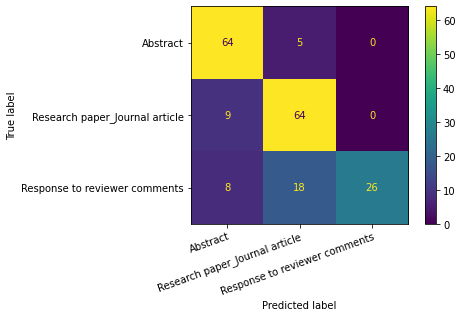

In [ ]:
#Running Rule based model and then testing it. 

#Taking out mvp documents
df_temp = df_allcat_test.loc[df_allcat_test.doc_category.isin(mvp_cat)].reset_index(drop = True)
df_length = len(df_temp)
features = rtrc_features
truth = []
pred = []
rtrc_threshold = 3
journal_threshold = 3
t1 = time()
for i in range(df_length):
  count = 0
  text = df_temp.text[i]
  truth_ = df_temp.doc_category[i]

  count_rtrc = 0
  for j in rtrc_features:
    if j in text:
      count_rtrc+=1

  if(count_rtrc > rtrc_threshold):
    pred_ = "Response to reviewer comments"
  elif df_temp.word_count[i] < 2500:
    pred_ = "Abstract"
  else:
    pred_ = "Research paper_Journal article"

  pred.append(pred_)
  truth.append(truth_)
t2 = time()
print(f'Average Inference time : {(t2-t1)/df_length}')

print(cr(truth, pred))
cmd(confusion_matrix=cm(truth,pred), display_labels=sorted(set(pred))).plot()
plt.xticks((0,1,2), sorted(set(pred)), rotation=20, rotation_mode="anchor", ha='right')
plt.show()

Average Inference time : 0.00015766280038016184
                                precision    recall  f1-score   support

                      Abstract       0.82      1.00      0.90        18
Research paper_Journal article       1.00      1.00      1.00        18
 Response to reviewer comments       1.00      0.80      0.89        20

                      accuracy                           0.93        56
                     macro avg       0.94      0.93      0.93        56
                  weighted avg       0.94      0.93      0.93        56



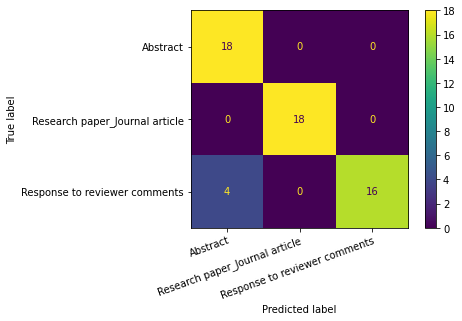

In [ ]:
#Testing on Gold Set
df_temp = full_gold.loc[full_gold.doc_category.isin(mvp_cat)].reset_index(drop = True)
df_length = len(df_temp)
features = rtrc_features
truth = []
pred = []
rtrc_threshold = 3
journal_threshold = 3
t1 = time()
for i in range(df_length):
  count = 0
  text = df_temp.text[i]
  truth_ = df_temp.doc_category[i]

  count_rtrc = 0
  for j in rtrc_features:
    if j in text:
      count_rtrc+=1

  if(count_rtrc > rtrc_threshold):
    pred_ = "Response to reviewer comments"
  elif df_temp.word_count[i] < 2500:
    pred_ = "Abstract"
  else:
    pred_ = "Research paper_Journal article"

  pred.append(pred_)
  truth.append(truth_)
t2 = time()
print(f'Average Inference time : {(t2-t1)/df_length}')
print(cr(truth, pred))
cmd(confusion_matrix=cm(truth,pred), display_labels=sorted(set(pred))).plot()
plt.xticks((0,1,2), sorted(set(pred)), rotation=20, rotation_mode="anchor", ha='right')
plt.show()

# Experiment 1(a) : Vanilla (MVP)

In [ ]:
tfidf = TfidfVectorizer()
rfc = RandomForestClassifier(random_state = 32)

In [ ]:
experiment = {
    "clf":RandomForestClassifier(random_state = 42),
    "vectorizer": TfidfVectorizer(), 
    "X": df_allcat_train_cv.text,
    "y":df_allcat_train_cv.doc_category, 
    "model_details": '''"clf":RandomForestClassifier(random_state = 42),
    "vectorizer": TfidfVectorizer()''',
    "title": "Vanilla Experiment"
}
r = benchmark(**experiment)
results["vanilla"] = r

In [ ]:
df_train_mvp = df_allcat_train_cv.loc[df_allcat_train_cv.doc_category.isin(mvp_cat)].reset_index(drop = True)
gold_mvp = full_gold.loc[full_gold.doc_category.isin(mvp_cat)].reset_index(drop = True)
df_ = df.sample(frac=1, random_state = 42).reset_index(drop = True) 
df_mvp = df_.loc[df_.doc_category.isin(mvp_cat)].reset_index(drop = True)

*************Cross_Validation_Results**********
fit_time                   12.510994
score_time                  1.197929
test_accuracy               0.718738
test_rp_precision           0.655792
test_rtrc_precision         0.929621
test_abstract_precision     0.706911
test_rp_recall              0.872973
test_weighted_f1_score      0.708080
test_precision_weighted     0.740129
test_recall_weighted        0.718738
dtype: float64
*************Gold_Data_Test_Results************
                                precision    recall  f1-score   support

                      Abstract       1.00      1.00      1.00        18
Research paper_Journal article       1.00      1.00      1.00        18
 Response to reviewer comments       1.00      1.00      1.00        20

                      accuracy                           1.00        56
                     macro avg       1.00      1.00      1.00        56
                  weighted avg       1.00      1.00      1.00        56



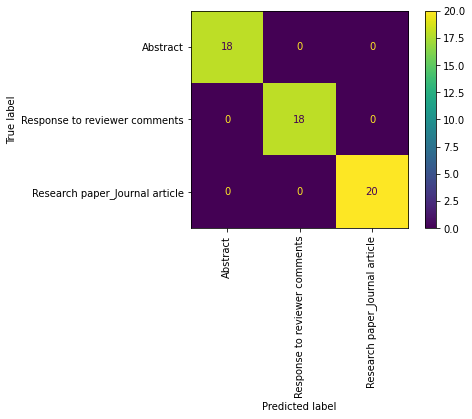

{'vectorizing_time': 0.0013463454587118967, 'inference_time': 0.0010229519435337611, 'feature_vector_size': 141364}


In [ ]:
#Only MVP Categories
#Gold
X_train = df_train_mvp.text
y_train = df_train_mvp.doc_category
tfidf = TfidfVectorizer().fit(X_train)
X_train = tfidf.transform(X_train)
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(X_train, y_train)

print("*************Cross_Validation_Results**********")
pipe = Pipeline([("tfidf",tfidf), ("rfc", rfc)])
cv_result  = cross_validate(pipe, df_.text, df_.doc_category, cv = 5, scoring = scorer)
print(pd.DataFrame(cv_result).mean(axis = 0))
print("*************Gold_Data_Test_Results************")

gold_res = {}
y_true_gold = gold_mvp.doc_category
t1 = time()
X_gold = tfidf.transform(gold_mvp.text)
t2 = time()
y_pred_gold = rfc.predict(X_gold)
t3 = time()
gold_res["vectorizing_time"] = (t2-t1)/X_gold.shape[0]
gold_res["inference_time"] = (t3-t2)/X_gold.shape[0]
gold_res["feature_vector_size"] = X_gold.shape[1]
print(cr(gold_mvp.doc_category, y_pred_gold))
cmd(confusion_matrix=cm(y_true_gold,y_pred_gold), display_labels=y_true_gold.unique()).plot(xticks_rotation='vertical')
plt.show()
print(gold_res)

# Experiment 1(b): Only MVP but with Stemming

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


*************Cross_Validation_Results**********
fit_time                   129.356025
score_time                  30.669958
test_accuracy                0.716883
test_rp_precision            0.652388
test_rtrc_precision          0.912660
test_abstract_precision      0.708350
test_rp_recall               0.871622
test_weighted_f1_score       0.704638
test_precision_weighted      0.735948
test_recall_weighted         0.716883
dtype: float64
*************Gold_Data_Test_Results************
                                precision    recall  f1-score   support

                      Abstract       1.00      1.00      1.00        18
Research paper_Journal article       1.00      1.00      1.00        18
 Response to reviewer comments       1.00      1.00      1.00        20

                      accuracy                           1.00        56
                     macro avg       1.00      1.00      1.00        56
                  weighted avg       1.00      1.00      1.00        56



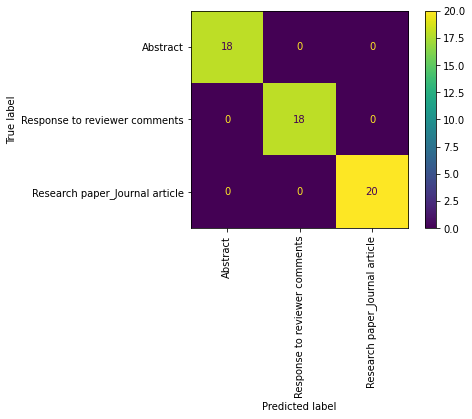

{'vectorizing_time': 0.0425871695790972, 'inference_time': 0.000898029123033796, 'feature_vector_size': 119864}


In [ ]:
#Only MVP Categories but with Stemming
#Gold
X_train = df_train_mvp.text
y_train = df_train_mvp.doc_category
tfidf = TfidfVectorizer(tokenizer = tokenize).fit(X_train)
X_train = tfidf.transform(X_train)
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(X_train, y_train)

print("*************Cross_Validation_Results**********")
pipe = Pipeline([("tfidf",tfidf), ("rfc", rfc)])
cv_result  = cross_validate(pipe, df_.text, df_.doc_category, cv = 5, scoring = scorer)
print(pd.DataFrame(cv_result).mean(axis = 0))
print("*************Gold_Data_Test_Results************")

gold_res = {}
y_true_gold = gold_mvp.doc_category
t1 = time()
X_gold = tfidf.transform(gold_mvp.text)
t2 = time()
y_pred_gold = rfc.predict(X_gold)
t3 = time()
gold_res["vectorizing_time"] = (t2-t1)/X_gold.shape[0]
gold_res["inference_time"] = (t3-t2)/X_gold.shape[0]
gold_res["feature_vector_size"] = X_gold.shape[1]
print(cr(gold_mvp.doc_category, y_pred_gold))
cmd(confusion_matrix=cm(y_true_gold,y_pred_gold), display_labels=y_true_gold.unique()).plot(xticks_rotation='vertical')
plt.show()
print(gold_res)

# Experiment 2(a): Including Other Categories

*************Cross_Validation_Results**********
fit_time                   11.637817
score_time                  1.129469
test_accuracy               0.722820
test_rp_precision           0.658368
test_rtrc_precision         0.934040
test_abstract_precision     0.708478
test_rp_recall              0.868919
test_weighted_f1_score      0.712674
test_precision_weighted     0.743669
test_recall_weighted        0.722820
dtype: float64
*************Gold_Data_Test_Results************
                                precision    recall  f1-score   support

                      Abstract       0.89      0.94      0.92        18
                         Other       0.89      0.55      0.68        29
Research paper_Journal article       0.63      0.94      0.76        18
 Response to reviewer comments       0.95      1.00      0.98        20

                      accuracy                           0.82        85
                     macro avg       0.84      0.86      0.83        85
             

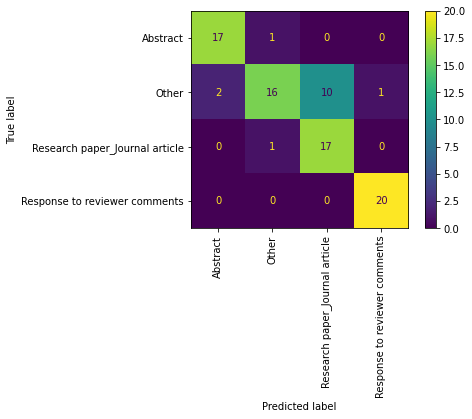

{'vectorizing_time': 0.0018069014829747818, 'inference_time': 0.0009675586924833409, 'feature_vector_size': 167507}


In [ ]:
#With "Other" Categories
#Gold
X_train = df_allcat_train_cv.text
y_train = df_allcat_train_cv.doc_category
tfidf = TfidfVectorizer().fit(X_train)
X_train = tfidf.transform(X_train)
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(X_train, y_train)

print("*************Cross_Validation_Results**********")
pipe = Pipeline([("tfidf",tfidf), ("rfc", rfc)])
df_ = df.sample(frac=1).reset_index(drop = True) 
cv_result  = cross_validate(pipe, df_.text, df_.doc_category, cv = 5, scoring = scorer)
print(pd.DataFrame(cv_result).mean(axis = 0))
print("*************Gold_Data_Test_Results************")
gold_res = {}
y_true_gold = full_gold.doc_category
t1 = time()
X_gold = tfidf.transform(full_gold.text)
t2 = time()
y_pred_gold = rfc.predict(X_gold)
t3 = time()
gold_res["vectorizing_time"] = (t2-t1)/X_gold.shape[0]
gold_res["inference_time"] = (t3-t2)/X_gold.shape[0]
gold_res["feature_vector_size"] = X_gold.shape[1]
print(cr(full_gold.doc_category, y_pred_gold))
cmd(confusion_matrix=cm(y_true_gold,y_pred_gold), display_labels=sorted(y_true_gold.unique())).plot(xticks_rotation='vertical')
plt.show()
print(gold_res)

# Experiment 2(b): Including Other Categories and Stemming

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


*************Cross_Validation_Results**********
fit_time                   130.454552
score_time                  30.950510
test_accuracy                0.716512
test_rp_precision            0.647885
test_rtrc_precision          0.909760
test_abstract_precision      0.706102
test_rp_recall               0.872973
test_weighted_f1_score       0.704082
test_precision_weighted      0.737550
test_recall_weighted         0.716512
dtype: float64
*************Gold_Data_Test_Results************
                                precision    recall  f1-score   support

                      Abstract       0.85      0.94      0.89        18
                         Other       0.83      0.34      0.49        29
Research paper_Journal article       0.60      1.00      0.75        18
 Response to reviewer comments       0.83      0.95      0.88        20

                      accuracy                           0.75        85
                     macro avg       0.78      0.81      0.75        85
   

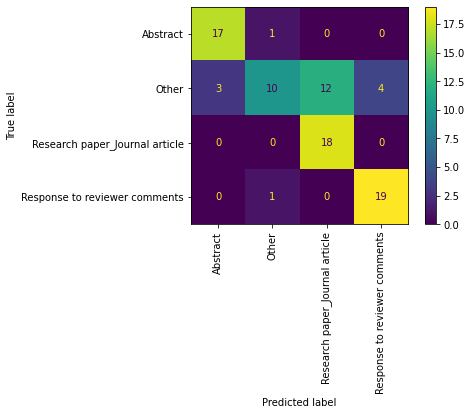

{'vectorizing_time': 0.05761506136725931, 'inference_time': 0.0007804169374353746, 'feature_vector_size': 142468}


In [ ]:
#With "Other" Categories but with stemming
#Gold
X_train = df_allcat_train_cv.text
y_train = df_allcat_train_cv.doc_category
tfidf = TfidfVectorizer(tokenizer = tokenize).fit(X_train)
X_train = tfidf.transform(X_train)
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(X_train, y_train)

print("*************Cross_Validation_Results**********")
pipe = Pipeline([("tfidf",tfidf), ("rfc", rfc)])
df_ = df.sample(frac=1).reset_index(drop = True) 
cv_result  = cross_validate(pipe, df_.text, df_.doc_category, cv = 5, scoring = scorer)
print(pd.DataFrame(cv_result).mean(axis = 0))
print("*************Gold_Data_Test_Results************")
gold_res = {}
y_true_gold = full_gold.doc_category
t1 = time()
X_gold = tfidf.transform(full_gold.text)
t2 = time()
y_pred_gold = rfc.predict(X_gold)
t3 = time()
gold_res["vectorizing_time"] = (t2-t1)/X_gold.shape[0]
gold_res["inference_time"] = (t3-t2)/X_gold.shape[0]
gold_res["feature_vector_size"] = X_gold.shape[1]
print(cr(full_gold.doc_category, y_pred_gold))
cmd(confusion_matrix=cm(y_true_gold,y_pred_gold), display_labels=sorted(y_true_gold.unique())).plot(xticks_rotation='vertical')
plt.show()
print(gold_res)

# Experiment 3(a): Removing Stopwords and using min_df

*************Cross_Validation_Results**********
fit_time                   7.554845
score_time                 0.860646
test_accuracy              0.734323
test_rp_precision          0.667497
test_rtrc_precision        0.911841
test_abstract_precision    0.793839
test_rp_recall             0.855405
test_weighted_f1_score     0.731625
test_precision_weighted    0.747927
test_recall_weighted       0.734323
dtype: float64


*************Gold_Data_Test_Results************
                                precision    recall  f1-score   support

                      Abstract       0.94      0.89      0.91        18
                         Other       0.90      0.62      0.73        29
Research paper_Journal article       0.69      1.00      0.82        18
 Response to reviewer comments       0.91      1.00      0.95        20

                      accuracy                           0.85        85
                     macro avg       0.86      0.88      0.85        85
                  wei

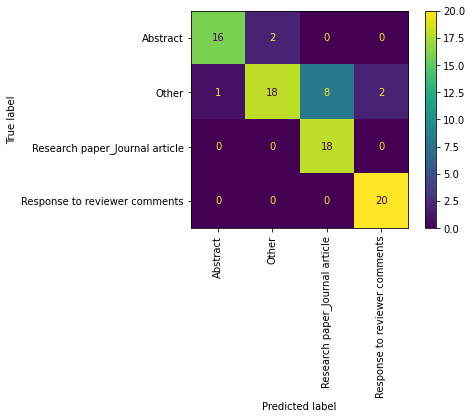

{'vectorizing_time': 0.0016681502847110524, 'inference_time': 0.00021100324742934283, 'feature_vector_size': 823}


In [ ]:
#After removing stopwords min_df
tfidf_min_max_df = TfidfVectorizer(stop_words = "english", use_idf = True, min_df = 0.1111, max_df = 0.9999)
X_text = tfidf_min_max_df.fit_transform(df_allcat_train_cv.text)
rfc_min_max = RandomForestClassifier(random_state = 42, n_estimators = 100)
rfc_min_max.fit(X_text, df_allcat_train_cv.doc_category)

print("*************Cross_Validation_Results**********")
pipe = Pipeline([("tfidf",tfidf_min_max_df), ("rfc", rfc_min_max)])
df_ = df.sample(frac=1).reset_index(drop = True) 
cv_result  = cross_validate(pipe, df_.text, df_.doc_category, cv = 5, scoring = scorer)
print(pd.DataFrame(cv_result).mean(axis = 0))
print("\n\n*************Gold_Data_Test_Results************")
gold_res = {}
y_true_gold = full_gold.doc_category
t1 = time()
X_gold = tfidf_min_max_df.transform(full_gold.text)
t2 = time()
y_pred_gold = rfc_min_max.predict(X_gold)
t3 = time()
gold_res["vectorizing_time"] = (t2-t1)/X_gold.shape[0]
gold_res["inference_time"] = (t3-t2)/X_gold.shape[0]
gold_res["feature_vector_size"] = X_gold.shape[1]
print(cr(full_gold.doc_category, y_pred_gold))
cmd(confusion_matrix=cm(y_true_gold,y_pred_gold), display_labels=sorted(y_true_gold.unique())).plot(xticks_rotation='vertical')
plt.show()
print(gold_res)

# Experiment 3(b): Removing Stopwords and using min_df + Stemming

*************Cross_Validation_Results**********
fit_time                   127.647214
score_time                  30.921994
test_accuracy                0.739889
test_rp_precision            0.670317
test_rtrc_precision          0.903302
test_abstract_precision      0.764002
test_rp_recall               0.862162
test_weighted_f1_score       0.734405
test_precision_weighted      0.751331
test_recall_weighted         0.739889
dtype: float64


*************Gold_Data_Test_Results************
                                precision    recall  f1-score   support

                      Abstract       0.94      0.94      0.94        18
                         Other       0.95      0.62      0.75        29
Research paper_Journal article       0.72      1.00      0.84        18
 Response to reviewer comments       0.87      1.00      0.93        20

                      accuracy                           0.86        85
                     macro avg       0.87      0.89      0.87        85
 

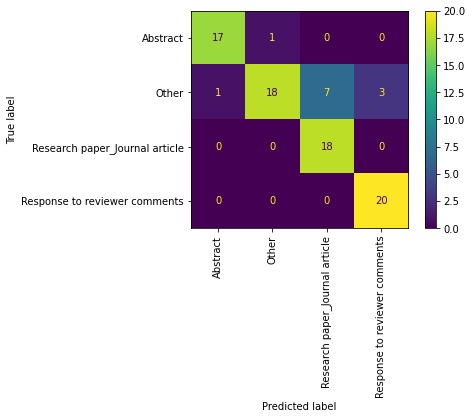

{'vectorizing_time': 0.05826572810902315, 'inference_time': 0.00021786970250746782, 'feature_vector_size': 882}


In [ ]:
#After removing stopwords min_df with stemming
tfidf_min_max_df = TfidfVectorizer(use_idf = True, min_df = 0.1111, max_df = 0.9999, tokenizer = tokenize)
X_text = tfidf_min_max_df.fit_transform(df_allcat_train_cv.text)
rfc_min_max = RandomForestClassifier(random_state = 42, n_estimators = 100)
rfc_min_max.fit(X_text, df_allcat_train_cv.doc_category)

print("*************Cross_Validation_Results**********")
pipe = Pipeline([("tfidf",tfidf_min_max_df), ("rfc", rfc_min_max)])
df_ = df.sample(frac=1).reset_index(drop = True) 
cv_result  = cross_validate(pipe, df_.text, df_.doc_category, cv = 5, scoring = scorer)
print(pd.DataFrame(cv_result).mean(axis = 0))
print("\n\n*************Gold_Data_Test_Results************")
gold_res = {}
y_true_gold = full_gold.doc_category
t1 = time()
X_gold = tfidf_min_max_df.transform(full_gold.text)
t2 = time()
y_pred_gold = rfc_min_max.predict(X_gold)
t3 = time()
gold_res["vectorizing_time"] = (t2-t1)/X_gold.shape[0]
gold_res["inference_time"] = (t3-t2)/X_gold.shape[0]
gold_res["feature_vector_size"] = X_gold.shape[1]
print(cr(full_gold.doc_category, y_pred_gold))
cmd(confusion_matrix=cm(y_true_gold,y_pred_gold), display_labels=sorted(y_true_gold.unique())).plot(xticks_rotation='vertical')
plt.show()
print(gold_res)

*************Cross_Validation_Results**********
fit_time                   128.875443
score_time                  31.544054
test_accuracy                0.736178
test_rp_precision            0.661663
test_rtrc_precision          0.911710
test_abstract_precision      0.747287
test_rp_recall               0.871622
test_weighted_f1_score       0.729117
test_precision_weighted      0.751867
test_recall_weighted         0.736178
dtype: float64


*************Gold_Data_Test_Results************
                                precision    recall  f1-score   support

                      Abstract       0.94      0.94      0.94        18
                         Other       0.89      0.55      0.68        29
Research paper_Journal article       0.64      1.00      0.78        18
 Response to reviewer comments       0.90      0.95      0.93        20

                      accuracy                           0.82        85
                     macro avg       0.85      0.86      0.83        85
 

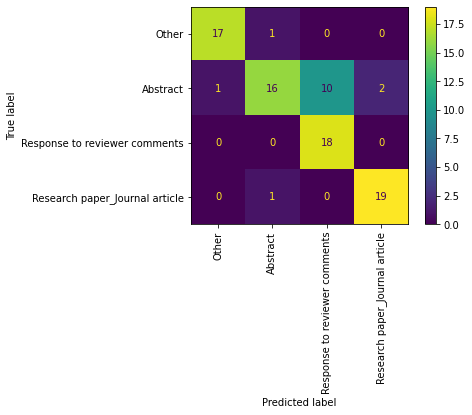

{'feature_vector_size': 882,
 'inference_time': 0.00017118453979492188,
 'vectorizing_time': 0.058965635299682614}

In [ ]:
#After removing stopwords min_df and regularising
tfidf_min_max_df = TfidfVectorizer( use_idf = True, min_df = 0.1111, max_df = 0.9999, tokenizer = tokenize)
X_text = tfidf_min_max_df.fit_transform(df_allcat_train_cv.text)
rfc_min_max_regu = RandomForestClassifier(random_state = 42, n_estimators = 100, max_depth = 15)
rfc_min_max_regu.fit(X_text, df_allcat_train_cv.doc_category)

print("*************Cross_Validation_Results**********")
pipe = Pipeline([("tfidf",tfidf_min_max_df), ("rfc", rfc_min_max_regu)])
df_ = df.sample(frac=1).reset_index(drop = True) 
cv_result  = cross_validate(pipe, df_.text, df_.doc_category, cv = 5, scoring = scorer)
print(pd.DataFrame(cv_result).mean(axis = 0))
print("\n\n*************Gold_Data_Test_Results************")

gold_res = {}
y_true_gold = full_gold.doc_category
t1 = time()
X_gold_min_max_df = tfidf_min_max_df.transform(full_gold.text).toarray()
t2 = time()
y_pred_gold = rfc_min_max_regu.predict(X_gold_min_max_df)
t3 = time()
gold_res["vectorizing_time"] = (t2-t1)/X_gold_min_max_df.shape[0]
gold_res["inference_time"] = (t3-t2)/X_gold_min_max_df.shape[0]
gold_res["feature_vector_size"] = X_gold_min_max_df.shape[1]
print(cr(full_gold.doc_category, y_pred_gold))
cmd(confusion_matrix=cm(y_true_gold,y_pred_gold), display_labels=y_true_gold.unique()).plot(xticks_rotation='vertical')
plt.show()
gold_res

# Experiment 3(c): Pruning

In [ ]:
def create_classifier_signature(tree, df, rfc_, tfidf):
  '''
  x_test should be in vectorised form 
  '''
  x_test = tfidf.transform(list(df.text))
  classes = rfc_.classes_
  y_test = df.doc_category
  pred_tree = tree.predict(x_test)
  dd  ={}
  for k,v in enumerate(classes):
    dd[k] = v
  pred_classes = [dd[i] for i in pred_tree]

  #Calculating Signature of a tree 
  signature = np.empty(pred_tree.shape)
  for i, j in enumerate(pred_classes):
    if j == y_test[i]:
      signature[i] = 1
    else:
      signature[i] = -1
  return signature

In [ ]:
def lambda_(x):
  o = np.ones(x.shape)
  l = (-o @ x) / (np.linalg.norm(x))**2
  return l
def encode(y, rfc_):
  '''
  This is needed to convert labels to indexes as estimators give output 
  in terms of index and not labels. 
  This will be needed for calculating orientations wrt reference vector
  '''
  classes = rfc_.classes_
  dd = {}
  for k,v in enumerate(classes):
    dd[v] = k
  label = np.empty(y.shape)
  for i,j in enumerate(y):
    label[i] = dd[j]
  return label
def prune_rf(rfc, tfidf, df):
  '''
  Takes classifier object, vectoriser, and data
  returns ensemble of selected tree(pruned classifier). 
  '''
  '''
  Step 1: Create A signature vector for every estimator in the ensemble
  Step 2: Calculate reference vector for the entire ensemble. 
  Step 3: Calculate Orientations of each estimator wrt reference vector using
  signature vector of each estimator
  Step 4: #Selecting thw DT's that are in first quadrant of rf_reference_vector 
  and rf_signature_vector
  Step 5: Create ensemble of Selected trees
  '''
  print("Step 1: Create A signature vector for every estimator in the ensemble")

  rfc_signature_list = []
  for i in tqdm(range(len(rfc.estimators_))):
    classifier_signature = create_classifier_signature(rfc.estimators_[i], df_allcat_train_cv, rfc, tfidf)
    rfc_signature_list.append(classifier_signature)
  rfc_signature_list = np.array(rfc_signature_list)

  print("\nStep 2: Calculate reference vector for the entire ensemble.")
  #Calculating the reference vector rf
  rfc_signature_vector = np.average(rfc_signature_list, axis = 0)
  alph = lambda_(rfc_signature_vector)
  rfc_reference_vector = np.ones(rfc_signature_vector.shape) + alph * rfc_signature_vector
  rfc_reference_vector.shape

  print("\nStep 3: Calculate Orientations")
  #Calculating Orientations for each estimator
  dot  = rfc_signature_list @ rfc_reference_vector
  orientations = dot / np.linalg.norm(rfc_signature_list, axis = 1) / np.linalg.norm(rfc_reference_vector)

  print("\nStep 4: #Selecting thw DT's")
  #Selecting thw DT's that are in first quadrant of rfc_reference_vector and rfc_signature_vector
  final_ensemble = []
  for i,j in enumerate(orientations):
    if j < 1.57 and j > 0:
      final_ensemble.append(rfc.estimators_[i])

  #Creating ensemble of selected trees

  print("\nStep 5: Create ensemble of Selected trees")
  #######################################
  #Some workaround
  import six
  import sys
  sys.modules['sklearn.externals.six'] = six

  #######################################
  from mlxtend.classifier import EnsembleVoteClassifier
  import copy
  eclf = EnsembleVoteClassifier(clfs=final_ensemble, weights=list(np.ones(len(final_ensemble))), refit=False)

  X_train_small = tfidf.transform(df.text)

  y_train = encode(df.doc_category, rfc) #This has to be encoded form or else it fails

  eclf.fit(X_train_small,y_train)

  #Putting the classes back in the eclf. this is imp since when you are pickeling, these classes names need to go along
  eclf.classes_ = rfc.classes_

  return {"pruned_rfc":eclf, "reference_vector":rfc_reference_vector, "selected_trees": final_ensemble, "rfc_signature_list":rfc_signature_list}

In [ ]:
def scorer_eclf(rfc, X, y):
  y_pred = rfc.classes_[rfc.predict(X).astype(int)]
  cr_ = cr(y, y_pred, output_dict = True)
  res = {
      "accuracy":cr_["accuracy"],
      "rp_precision":cr_["Research paper_Journal article"]["precision"], 
      "rtrc_precision":cr_["Response to reviewer comments"]["precision"],
      "abstract_precision":cr_["Abstract"]["precision"],
      "rp_recall":cr_['Research paper_Journal article']["recall"],
      "weighted_f1_score":cr_['weighted avg']["f1-score"],
      "precision_weighted":cr_['weighted avg']['precision'],
      "recall_weighted":cr_['weighted avg']['recall']
  }
  return res

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
fold = 1
results = []
df_temp = df.sample(frac=1).reset_index(drop=True)
for train_index, test_index in kf.split(df):
  print("-"*100)
  print(f"\nTraining for fold: {fold}")
  fold+=1
  tfidf_min_max_df = TfidfVectorizer(stop_words = "english", use_idf = True, min_df = 0.1111, max_df = 0.9999)
  X_text = tfidf_min_max_df.fit_transform(df_temp.iloc[train_index,:].text)
  rfc_min_max = RandomForestClassifier(random_state = 42, n_estimators = 100)
  rfc_min_max.fit(X_text, df_temp.iloc[train_index,:].doc_category)

  print("\nPruning started....")

  pruning = prune_rf(rfc_min_max, tfidf_min_max_df, df_temp.iloc[train_index,:])
  clf = pruning["pruned_rfc"]
  print("\nPruning Done. Scoring Pruned Forest...")
  res = scorer_eclf(clf, tfidf_min_max_df.transform(df_temp.loc[test_index,:].text), df_temp.loc[test_index,:].doc_category)
  results.append(res)

----------------------------------------------------------------------------------------------------

Training for fold: 1

Pruning started....
Step 1: Create A signature vector for every estimator in the ensemble


100%|██████████| 100/100 [05:55<00:00,  3.55s/it]



Step 2: Calculate reference vector for the entire ensemble.

Step 3: Calculate Orientations

Step 4: #Selecting thw DT's

Step 5: Create ensemble of Selected trees

Pruning Done. Scoring Pruned Forest...
----------------------------------------------------------------------------------------------------

Training for fold: 2

Pruning started....
Step 1: Create A signature vector for every estimator in the ensemble


100%|██████████| 100/100 [05:47<00:00,  3.47s/it]



Step 2: Calculate reference vector for the entire ensemble.

Step 3: Calculate Orientations

Step 4: #Selecting thw DT's

Step 5: Create ensemble of Selected trees

Pruning Done. Scoring Pruned Forest...
----------------------------------------------------------------------------------------------------

Training for fold: 3

Pruning started....
Step 1: Create A signature vector for every estimator in the ensemble


100%|██████████| 100/100 [05:52<00:00,  3.53s/it]



Step 2: Calculate reference vector for the entire ensemble.

Step 3: Calculate Orientations

Step 4: #Selecting thw DT's

Step 5: Create ensemble of Selected trees

Pruning Done. Scoring Pruned Forest...
----------------------------------------------------------------------------------------------------

Training for fold: 4

Pruning started....
Step 1: Create A signature vector for every estimator in the ensemble


100%|██████████| 100/100 [05:58<00:00,  3.59s/it]



Step 2: Calculate reference vector for the entire ensemble.

Step 3: Calculate Orientations

Step 4: #Selecting thw DT's

Step 5: Create ensemble of Selected trees

Pruning Done. Scoring Pruned Forest...
----------------------------------------------------------------------------------------------------

Training for fold: 5

Pruning started....
Step 1: Create A signature vector for every estimator in the ensemble


100%|██████████| 100/100 [06:00<00:00,  3.60s/it]



Step 2: Calculate reference vector for the entire ensemble.

Step 3: Calculate Orientations

Step 4: #Selecting thw DT's

Step 5: Create ensemble of Selected trees

Pruning Done. Scoring Pruned Forest...


In [ ]:
pd.DataFrame(results).mean(axis = 0)

accuracy              0.745455
rp_precision          0.667139
rtrc_precision        0.919581
abstract_precision    0.798874
rp_recall             0.851244
weighted_f1_score     0.744355
precision_weighted    0.762484
recall_weighted       0.745455
dtype: float64

Building Forest...

Pruning Forest...
Step 1: Create A signature vector for every estimator in the ensemble


100%|██████████| 100/100 [05:59<00:00,  3.60s/it]



Step 2: Calculate reference vector for the entire ensemble.

Step 3: Calculate Orientations

Step 4: #Selecting thw DT's

Step 5: Create ensemble of Selected trees


*************Gold_Data_Test_Results************
                                precision    recall  f1-score   support

                      Abstract       0.94      0.94      0.94        18
                         Other       0.91      0.69      0.78        29
Research paper_Journal article       0.71      0.94      0.81        18
 Response to reviewer comments       0.90      0.95      0.93        20

                      accuracy                           0.86        85
                     macro avg       0.87      0.88      0.87        85
                  weighted avg       0.87      0.86      0.86        85



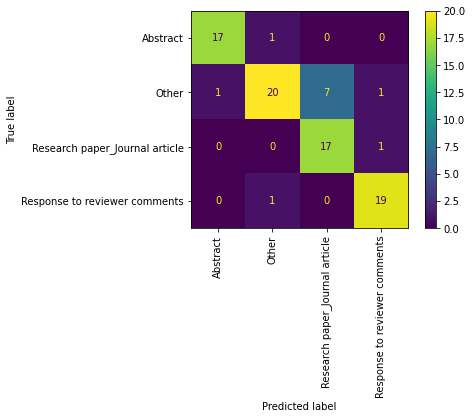

{'vectorizing_time': 0.0015770799973431756, 'inference_time': 0.00021413915297564337, 'feature_vector_size': 823}


In [ ]:
#Testing Pruned Tree on GoldSet
tfidf_min_max_df = TfidfVectorizer(stop_words = "english", use_idf = True, min_df = 0.1111, max_df = 0.9999)
X_text = tfidf_min_max_df.fit_transform(df_allcat_train_cv.text)
rfc_min_max = RandomForestClassifier(random_state = 42, n_estimators = 100)
print("Building Forest...")
rfc_min_max.fit(X_text, df_allcat_train_cv.doc_category)
print("\nPruning Forest...")
pruning = prune_rf(rfc_min_max, tfidf_min_max_df, df_allcat_train_cv)
clf = pruning["pruned_rfc"]
print("\n\n*************Gold_Data_Test_Results************")
gold_res = {}
y_true_gold = full_gold.doc_category
t1 = time()
X_gold = tfidf_min_max_df.transform(full_gold.text)
t2 = time()
y_pred_gold = clf.classes_[clf.predict(X_gold).astype(int)]
t3 = time()
gold_res["vectorizing_time"] = (t2-t1)/X_gold.shape[0]
gold_res["inference_time"] = (t3-t2)/X_gold.shape[0]
gold_res["feature_vector_size"] = X_gold.shape[1]
print(cr(full_gold.doc_category, y_pred_gold))
cmd(confusion_matrix=cm(y_true_gold,y_pred_gold), display_labels=sorted(y_true_gold.unique())).plot(xticks_rotation='vertical')
plt.show()
print(gold_res)

In [ ]:
import pickle
pickle.dump(clf, open("estimator_v3_c_pruned.sav", "wb"))
pickle.dump(tfidf_min_max_df, open("tfidf_v3_c_min_max_df.sav", "wb"))

In [ ]:
import pickle
import six
import sys
sys.modules['sklearn.externals.six'] = six
rr = pickle.load(open("estimator_v3_c_pruned.sav", "rb"))
vv = pickle.load(open("tfidf_v3_c_min_max_df.sav", "rb"))

In [ ]:
rr.predict(vv.transform(["methods abstract references conclusion"]))

array([0.])

# Experiment 4(a): Adding Class Weight

*************Cross_Validation_Results**********
fit_time                   9.000245
score_time                 0.845368
test_accuracy              0.740260
test_rp_precision          0.662210
test_rtrc_precision        0.918754
test_abstract_precision    0.766626
test_rp_recall             0.867568
test_weighted_f1_score     0.734822
test_precision_weighted    0.754933
test_recall_weighted       0.740260
dtype: float64


*************Gold_Data_Test_Results************
                                precision    recall  f1-score   support

                      Abstract       0.95      1.00      0.97        18
                         Other       0.89      0.59      0.71        29
Research paper_Journal article       0.65      0.94      0.77        18
 Response to reviewer comments       0.90      0.95      0.93        20

                      accuracy                           0.84        85
                     macro avg       0.85      0.87      0.85        85
                  wei

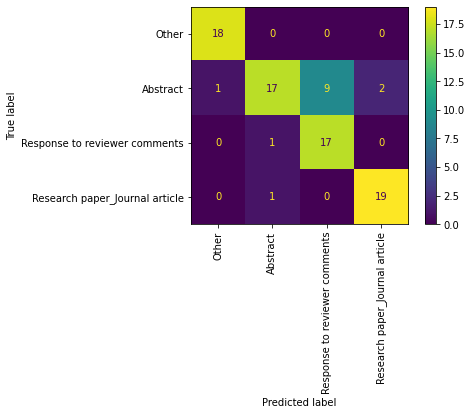

{'feature_vector_size': 823,
 'inference_time': 0.00018696784973144532,
 'vectorizing_time': 0.0016894873450784122}

In [ ]:
#Adding Class weight

tfidf_class_weight = TfidfVectorizer(stop_words= "english", use_idf = True, min_df = 0.1111, max_df = 0.999)
rfc_class_weight = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 32, class_weight = {'Research paper_Journal article':2, 'Abstract':1, 'Other':0.5,
       'Response to reviewer comments':1})
rfc_class_weight.fit(tfidf_class_weight.fit_transform(df_allcat_train_cv.text), df_allcat_train_cv.doc_category)

print("*************Cross_Validation_Results**********")
pipe = Pipeline([("tfidf",tfidf_class_weight), ("rfc", rfc_class_weight)])
df_ = df.sample(frac=1).reset_index(drop = True) 
cv_result  = cross_validate(pipe, df_.text, df_.doc_category, cv = 5, scoring = scorer)
print(pd.DataFrame(cv_result).mean(axis = 0))
print("\n\n*************Gold_Data_Test_Results************")

gold_res = {}
y_true_gold = full_gold.doc_category
t1 = time()
X_gold_class_weight = tfidf_class_weight.transform(full_gold.text).toarray()
t2 = time()
y_pred_gold = rfc_class_weight.predict(X_gold_class_weight)
t3 = time()
gold_res["vectorizing_time"] = (t2-t1)/X_gold_class_weight.shape[0]
gold_res["inference_time"] = (t3-t2)/X_gold_class_weight.shape[0]
gold_res["feature_vector_size"] = X_gold_class_weight.shape[1]
print(cr(full_gold.doc_category, y_pred_gold))
cmd(confusion_matrix=cm(y_true_gold,y_pred_gold), display_labels=y_true_gold.unique()).plot(xticks_rotation='vertical')
plt.show()
gold_res

# Experiment 4(b): Adding Class Weight and Stemming

*************Cross_Validation_Results**********
fit_time                   131.701400
score_time                  31.466984
test_accuracy                0.738404
test_rp_precision            0.658878
test_rtrc_precision          0.916349
test_abstract_precision      0.744077
test_rp_recall               0.871622
test_weighted_f1_score       0.729880
test_precision_weighted      0.755841
test_recall_weighted         0.738404
dtype: float64


*************Gold_Data_Test_Results************
                                precision    recall  f1-score   support

                      Abstract       0.85      0.94      0.89        18
                         Other       0.80      0.41      0.55        29
Research paper_Journal article       0.62      1.00      0.77        18
 Response to reviewer comments       0.86      0.90      0.88        20

                      accuracy                           0.76        85
                     macro avg       0.78      0.81      0.77        85
 

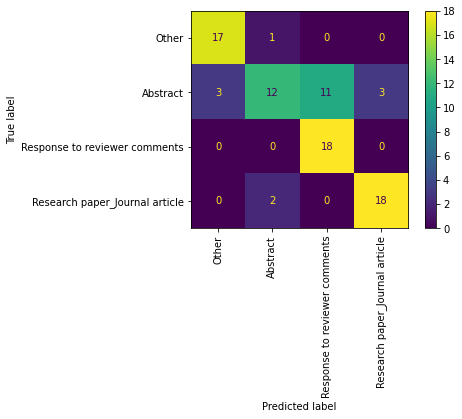

{'feature_vector_size': 882,
 'inference_time': 0.000187228707706227,
 'vectorizing_time': 0.06053234268637264}

In [ ]:
#Adding Class weight ans stemming

tfidf_class_weight = TfidfVectorizer(use_idf = True, min_df = 0.1111, max_df = 0.999, tokenizer = tokenize)
rfc_class_weight = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 32, class_weight = {'Research paper_Journal article':2, 'Abstract':1, 'Other':0.5,
       'Response to reviewer comments':1})
rfc_class_weight.fit(tfidf_class_weight.fit_transform(df_allcat_train_cv.text), df_allcat_train_cv.doc_category)

print("*************Cross_Validation_Results**********")
pipe = Pipeline([("tfidf",tfidf_class_weight), ("rfc", rfc_class_weight)])
df_ = df.sample(frac=1).reset_index(drop = True) 
cv_result  = cross_validate(pipe, df_.text, df_.doc_category, cv = 5, scoring = scorer)
print(pd.DataFrame(cv_result).mean(axis = 0))
print("\n\n*************Gold_Data_Test_Results************")

gold_res = {}
y_true_gold = full_gold.doc_category
t1 = time()
X_gold_class_weight = tfidf_class_weight.transform(full_gold.text).toarray()
t2 = time()
y_pred_gold = rfc_class_weight.predict(X_gold_class_weight)
t3 = time()
gold_res["vectorizing_time"] = (t2-t1)/X_gold_class_weight.shape[0]
gold_res["inference_time"] = (t3-t2)/X_gold_class_weight.shape[0]
gold_res["feature_vector_size"] = X_gold_class_weight.shape[1]
print(cr(full_gold.doc_category, y_pred_gold))
cmd(confusion_matrix=cm(y_true_gold,y_pred_gold), display_labels=y_true_gold.unique()).plot(xticks_rotation='vertical')
plt.show()
gold_res

# Experiment 4(c): Pruning

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
fold = 1
results = []
df_temp = df.sample(frac=1).reset_index(drop=True)
for train_index, test_index in kf.split(df):
  print("-"*100)
  print(f"\nTraining for fold: {fold}")
  fold+=1
  tfidf_class_weight = TfidfVectorizer(stop_words= "english", use_idf = True, min_df = 0.1111, max_df = 0.999)
  rfc_class_weight = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 32, class_weight = {'Research paper_Journal article':2, 'Abstract':1, 'Other':0.5,
        'Response to reviewer comments':1})
  rfc_class_weight.fit(tfidf_class_weight.fit_transform(df_temp.iloc[train_index,:].text), df_temp.iloc[train_index,:].doc_category)

  print("\nPruning started....")

  pruning = prune_rf(rfc_class_weight, tfidf_class_weight, df_temp.iloc[train_index,:])
  clf = pruning["pruned_rfc"]
  print("\nPruning Done. Scoring Pruned Forest...")
  res = scorer_eclf(clf, tfidf_class_weight.transform(df_temp.iloc[test_index,:].text), df_temp.iloc[test_index,:].doc_category)
  results.append(res)

----------------------------------------------------------------------------------------------------

Training for fold: 1

Pruning started....
Step 1: Create A signature vector for every estimator in the ensemble


100%|██████████| 100/100 [05:59<00:00,  3.59s/it]



Step 2: Calculate reference vector for the entire ensemble.

Step 3: Calculate Orientations

Step 4: #Selecting thw DT's

Step 5: Create ensemble of Selected trees

Pruning Done. Scoring Pruned Forest...
----------------------------------------------------------------------------------------------------

Training for fold: 2

Pruning started....
Step 1: Create A signature vector for every estimator in the ensemble


100%|██████████| 100/100 [05:59<00:00,  3.59s/it]



Step 2: Calculate reference vector for the entire ensemble.

Step 3: Calculate Orientations

Step 4: #Selecting thw DT's

Step 5: Create ensemble of Selected trees

Pruning Done. Scoring Pruned Forest...
----------------------------------------------------------------------------------------------------

Training for fold: 3

Pruning started....
Step 1: Create A signature vector for every estimator in the ensemble


100%|██████████| 100/100 [05:55<00:00,  3.55s/it]



Step 2: Calculate reference vector for the entire ensemble.

Step 3: Calculate Orientations

Step 4: #Selecting thw DT's

Step 5: Create ensemble of Selected trees

Pruning Done. Scoring Pruned Forest...
----------------------------------------------------------------------------------------------------

Training for fold: 4

Pruning started....
Step 1: Create A signature vector for every estimator in the ensemble


100%|██████████| 100/100 [05:57<00:00,  3.58s/it]



Step 2: Calculate reference vector for the entire ensemble.

Step 3: Calculate Orientations

Step 4: #Selecting thw DT's

Step 5: Create ensemble of Selected trees

Pruning Done. Scoring Pruned Forest...
----------------------------------------------------------------------------------------------------

Training for fold: 5

Pruning started....
Step 1: Create A signature vector for every estimator in the ensemble


100%|██████████| 100/100 [05:54<00:00,  3.55s/it]



Step 2: Calculate reference vector for the entire ensemble.

Step 3: Calculate Orientations

Step 4: #Selecting thw DT's

Step 5: Create ensemble of Selected trees

Pruning Done. Scoring Pruned Forest...


In [ ]:
pd.DataFrame(results).mean(axis = 0)

accuracy              0.737662
rp_precision          0.664440
rtrc_precision        0.898279
abstract_precision    0.776775
rp_recall             0.855509
weighted_f1_score     0.732675
precision_weighted    0.748836
recall_weighted       0.737662
dtype: float64

Building Forest...

Pruning Forest...
Step 1: Create A signature vector for every estimator in the ensemble


100%|██████████| 100/100 [06:08<00:00,  3.68s/it]



Step 2: Calculate reference vector for the entire ensemble.

Step 3: Calculate Orientations

Step 4: #Selecting thw DT's

Step 5: Create ensemble of Selected trees


*************Gold_Data_Test_Results************
                                precision    recall  f1-score   support

                      Abstract       0.89      0.94      0.92        18
                         Other       0.83      0.66      0.73        29
Research paper_Journal article       0.68      0.83      0.75        18
 Response to reviewer comments       0.90      0.95      0.93        20

                      accuracy                           0.82        85
                     macro avg       0.83      0.85      0.83        85
                  weighted avg       0.83      0.82      0.82        85



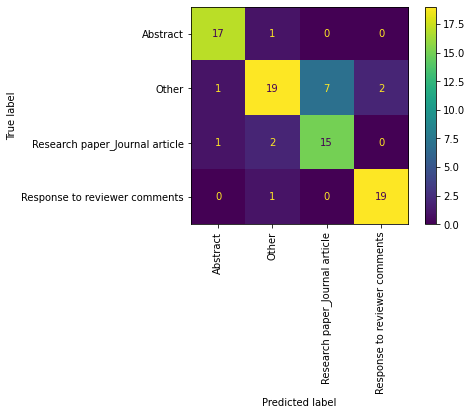

{'vectorizing_time': 0.001491700901704676, 'inference_time': 0.00021865227643181297, 'feature_vector_size': 823}


In [ ]:
#Testing Pruned Tree on GoldSet
tfidf_min_max_df = TfidfVectorizer(stop_words = "english", use_idf = True, min_df = 0.1111, max_df = 0.9999)
X_text = tfidf_min_max_df.fit_transform(df_allcat_train_cv.text)
rfc_min_max = RandomForestClassifier(n_estimators = 100, criterion = "entropy", \
                                     random_state = 32, class_weight = {'Research paper_Journal article':2, 'Abstract':1, 'Other':0.5,
        'Response to reviewer comments':1})
print("Building Forest...")
rfc_min_max.fit(X_text, df_allcat_train_cv.doc_category)
print("\nPruning Forest...")
pruning = prune_rf(rfc_min_max, tfidf_min_max_df, df_allcat_train_cv)
clf = pruning["pruned_rfc"]
print("\n\n*************Gold_Data_Test_Results************")
gold_res = {}
y_true_gold = full_gold.doc_category
t1 = time()
X_gold = tfidf_min_max_df.transform(full_gold.text)
t2 = time()
y_pred_gold = clf.classes_[clf.predict(X_gold).astype(int)]
t3 = time()
gold_res["vectorizing_time"] = (t2-t1)/X_gold.shape[0]
gold_res["inference_time"] = (t3-t2)/X_gold.shape[0]
gold_res["feature_vector_size"] = X_gold.shape[1]
print(cr(full_gold.doc_category, y_pred_gold))
cmd(confusion_matrix=cm(y_true_gold,y_pred_gold), display_labels=sorted(y_true_gold.unique())).plot(xticks_rotation='vertical')
plt.show()
print(gold_res)

# Experiment 5(a) : Multiclass to Multilabel

*************Cross_Validation_Results**********
fit_time                   8.092232
score_time                 0.822719
test_accuracy              0.687570
test_rp_precision          0.690410
test_rtrc_precision        0.932009
test_abstract_precision    0.810556
test_rp_recall             0.641708
test_weighted_f1_score     0.694643
test_precision_weighted    0.724905
test_recall_weighted       0.687570
dtype: float64


*************Gold_Data_Test_Results************
                                precision    recall  f1-score   support

                      Abstract       0.94      0.94      0.94        18
                         Other       0.75      0.93      0.83        29
Research paper_Journal article       0.93      0.78      0.85        18
 Response to reviewer comments       1.00      0.80      0.89        20

                      accuracy                           0.87        85
                     macro avg       0.91      0.86      0.88        85
                  wei

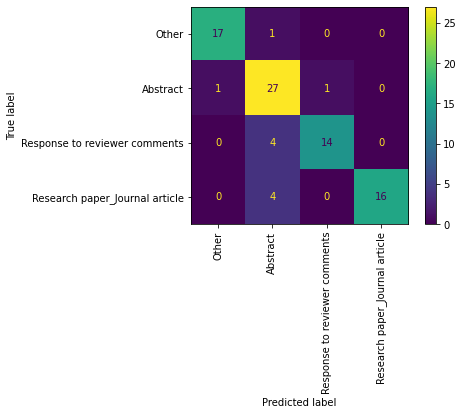

{'feature_vector_size': 823,
 'inference_time': 0.00023187749526079965,
 'vectorizing_time': 0.0014549956602208755}

In [ ]:
def test_multilabel(y_true, y_pred):
  # labels = {}
  labels = {('non-rp', 'non-rtrc', 'abstract'): 'Abstract', 
    ('non-rp', 'non-rtrc', 'non-abstract'): 'Other', 
    ('non-rp', 'rtrc', 'non-abstract'): 'Response to reviewer comments', 
    ('rp', 'non-rtrc', 'non-abstract'): 'Research paper_Journal article'}
  labels_ = ["Abstract", "Other", "Response to reviewer comments", "Research paper_Journal article"]
  # for i,j in enumerate(np.unique(np.array(y_pred).astype("<U22"), axis = 0)):
  #   labels[tuple(j)] = labels_[i]
  y_pred_simple = []
  for i in np.array(y_pred):
    y_pred_simple.append(labels[tuple(i)])
  return y_pred_simple

def predict(rfc, tfidf_text, tfidf_headings, df, headings_text = False):
  X_text = tfidf_text.transform(df.text)
  if headings_text:
    X_headings = tfidf_headings.transform(df.heading_text)
    X_total = hstack([X_text,X_headings,df[["word_count2","n_tables","n_images"]].astype(float)])
  else:
    X_total = hstack([X_text,df[["word_count2","n_tables","n_images"]].astype(float)])
  y_true = df.doc_category
  y_pred = rfc.predict(X_total)
  return y_true, y_pred

def scorer_multilabel(rfc, X, y):
  y_pred = rfc.predict(X)
  y_true_simple = test_multilabel(y, y)
  y_pred_simple = test_multilabel(y, y_pred)
  cr_ = cr(y_true_simple, y_pred_simple, output_dict = True)
  res = {
      "accuracy":cr_["accuracy"],
      "rp_precision":cr_["Research paper_Journal article"]["precision"], 
      "rtrc_precision":cr_["Response to reviewer comments"]["precision"],
      "abstract_precision":cr_["Abstract"]["precision"],
      "rp_recall":cr_['Research paper_Journal article']["recall"],
      "weighted_f1_score":cr_['weighted avg']["f1-score"],
      "precision_weighted":cr_['weighted avg']['precision'],
      "recall_weighted":cr_['weighted avg']['recall']
  }
  return res

class_weights= [
                {"rp":1, "non-rp":0.1},
                {"rtrc":1, "non-rtrc":0.5},
                {"abstract":1, "non-abstract":0.5}
]
tfidf_bucket = TfidfVectorizer(stop_words= "english", use_idf = True, norm = None, min_df = 0.1111, max_df = 0.999)
X = tfidf_bucket.fit_transform(df_allcat_train_cv.text)
rfc_bucket = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 32, class_weight = class_weights)
rfc_bucket.fit(X, df_allcat_train_cv[["rp","rtrc","abstract"]])

print("*************Cross_Validation_Results**********")
pipe = Pipeline([("tfidf",tfidf_bucket), ("rfc", rfc_bucket)])
df_ = df.sample(frac=1).reset_index(drop = True) 
cv_result  = cross_validate(pipe, df_.text, df_[["rp","rtrc","abstract"]], cv = 5, scoring = scorer_multilabel)
print(pd.DataFrame(cv_result).mean(axis = 0))

print("\n\n*************Gold_Data_Test_Results************")

gold_res = {}
y_true_gold = full_gold.doc_category
t1 = time()
X_gold_bucket = tfidf_bucket.transform(full_gold.text).toarray()
t2 = time()
y_pred_gold = rfc_bucket.predict(X_gold_bucket)
y_pred_simple_gold = test_multilabel(y_true_gold, y_pred_gold)
t3 = time()
gold_res["vectorizing_time"] = (t2-t1)/X_gold_bucket.shape[0]
gold_res["inference_time"] = (t3-t2)/X_gold_bucket.shape[0]
gold_res["feature_vector_size"] = X_gold_bucket.shape[1]
print(cr(full_gold.doc_category, y_pred_simple_gold))
cmd(confusion_matrix=cm(y_true_gold,y_pred_simple_gold), display_labels=y_true_gold.unique()).plot(xticks_rotation='vertical')
plt.show()
gold_res
# #On Gold
# y_pred = rfc.predict(tfidf.transform(full_gold.text))
# y_true = full_gold.doc_category
# y_pred_simple_gold = test_multilabel(y_true, y_pred)

In [ ]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.10.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2022.5.18.1
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.22.4
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.30
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.5.1
distribu

In [ ]:
import pickle
pickle.dump(tfidf_bucket, open("tfidf_bucket.sav", "wb"))
pickle.dump(rfc_bucket, open("rfc_bucket.sav", "wb"))

# Experiment 5(b): MultiLabel and using from uni to bigrams

*************Cross_Validation_Results**********
fit_time                   14.895399
score_time                  1.629524
test_accuracy               0.699814
test_rp_precision           0.705749
test_rtrc_precision         0.944573
test_abstract_precision     0.812062
test_rp_recall              0.648998
test_weighted_f1_score      0.705853
test_precision_weighted     0.734588
test_recall_weighted        0.699814
dtype: float64


*************Gold_Data_Test_Results************
                                precision    recall  f1-score   support

                      Abstract       1.00      0.94      0.97        18
                         Other       0.71      0.93      0.81        29
Research paper_Journal article       0.87      0.72      0.79        18
 Response to reviewer comments       1.00      0.75      0.86        20

                      accuracy                           0.85        85
                     macro avg       0.89      0.84      0.86        85
           

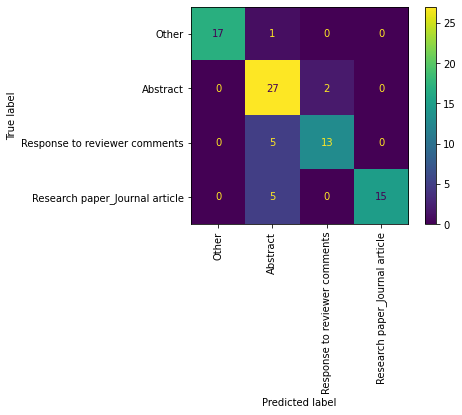

{'feature_vector_size': 836,
 'inference_time': 0.0002648634069106158,
 'vectorizing_time': 0.0030195516698500687}

In [ ]:
def test_multilabel(y_true, y_pred):
  # labels = {}
  labels = {('non-rp', 'non-rtrc', 'abstract'): 'Abstract', 
    ('non-rp', 'non-rtrc', 'non-abstract'): 'Other', 
    ('non-rp', 'rtrc', 'non-abstract'): 'Response to reviewer comments', 
    ('rp', 'non-rtrc', 'non-abstract'): 'Research paper_Journal article'}
  labels_ = ["Abstract", "Other", "Response to reviewer comments", "Research paper_Journal article"]
  # for i,j in enumerate(np.unique(np.array(y_pred).astype("<U22"), axis = 0)):
  #   labels[tuple(j)] = labels_[i]
  y_pred_simple = []
  for i in np.array(y_pred):
    y_pred_simple.append(labels[tuple(i)])
  return y_pred_simple

def predict(rfc, tfidf_text, tfidf_headings, df, headings_text = False):
  X_text = tfidf_text.transform(df.text)
  if headings_text:
    X_headings = tfidf_headings.transform(df.heading_text)
    X_total = hstack([X_text,X_headings,df[["word_count2","n_tables","n_images"]].astype(float)])
  else:
    X_total = hstack([X_text,df[["word_count2","n_tables","n_images"]].astype(float)])
  y_true = df.doc_category
  y_pred = rfc.predict(X_total)
  return y_true, y_pred

def scorer_multilabel(rfc, X, y):
  y_pred = rfc.predict(X)
  y_true_simple = test_multilabel(y, y)
  y_pred_simple = test_multilabel(y, y_pred)
  cr_ = cr(y_true_simple, y_pred_simple, output_dict = True)
  res = {
      "accuracy":cr_["accuracy"],
      "rp_precision":cr_["Research paper_Journal article"]["precision"], 
      "rtrc_precision":cr_["Response to reviewer comments"]["precision"],
      "abstract_precision":cr_["Abstract"]["precision"],
      "rp_recall":cr_['Research paper_Journal article']["recall"],
      "weighted_f1_score":cr_['weighted avg']["f1-score"],
      "precision_weighted":cr_['weighted avg']['precision'],
      "recall_weighted":cr_['weighted avg']['recall']
  }
  return res

class_weights= [
                {"rp":1, "non-rp":0.1},
                {"rtrc":1, "non-rtrc":0.5},
                {"abstract":1, "non-abstract":0.5}
]
tfidf_bucket = TfidfVectorizer(stop_words= "english", use_idf = True, norm = None, ngram_range = (1,2), min_df = 0.1111, max_df = 0.999)
X = tfidf_bucket.fit_transform(df_allcat_train_cv.text)
rfc_bucket = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 32, class_weight = class_weights)
rfc_bucket.fit(X, df_allcat_train_cv[["rp","rtrc","abstract"]])

print("*************Cross_Validation_Results**********")
pipe = Pipeline([("tfidf",tfidf_bucket), ("rfc", rfc_bucket)])
df_ = df.sample(frac=1).reset_index(drop = True) 
cv_result  = cross_validate(pipe, df_.text, df_[["rp","rtrc","abstract"]], cv = 5, scoring = scorer_multilabel)
print(pd.DataFrame(cv_result).mean(axis = 0))

print("\n\n*************Gold_Data_Test_Results************")

gold_res = {}
y_true_gold = full_gold.doc_category
t1 = time()
X_gold_bucket = tfidf_bucket.transform(full_gold.text).toarray()
t2 = time()
y_pred_gold = rfc_bucket.predict(X_gold_bucket)
y_pred_simple_gold = test_multilabel(y_true_gold, y_pred_gold)
t3 = time()
gold_res["vectorizing_time"] = (t2-t1)/X_gold_bucket.shape[0]
gold_res["inference_time"] = (t3-t2)/X_gold_bucket.shape[0]
gold_res["feature_vector_size"] = X_gold_bucket.shape[1]
print(cr(full_gold.doc_category, y_pred_simple_gold))
cmd(confusion_matrix=cm(y_true_gold,y_pred_simple_gold), display_labels=y_true_gold.unique()).plot(xticks_rotation='vertical')
plt.show()
gold_res
# #On Gold
# y_pred = rfc.predict(tfidf.transform(full_gold.text))
# y_true = full_gold.doc_category
# y_pred_simple_gold = test_multilabel(y_true, y_pred)

# Experiment 5(c): Multilabel, class weights, bigrams, Stemming

*************Cross_Validation_Results**********
fit_time                   133.273586
score_time                  31.216159
test_accuracy                0.692022
test_rp_precision            0.698168
test_rtrc_precision          0.953421
test_abstract_precision      0.790908
test_rp_recall               0.658223
test_weighted_f1_score       0.697552
test_precision_weighted      0.727902
test_recall_weighted         0.692022
dtype: float64


*************Gold_Data_Test_Results************
                                precision    recall  f1-score   support

                      Abstract       0.94      0.94      0.94        18
                         Other       0.74      0.86      0.79        29
Research paper_Journal article       0.82      0.78      0.80        18
 Response to reviewer comments       1.00      0.80      0.89        20

                      accuracy                           0.85        85
                     macro avg       0.88      0.85      0.86        85
 

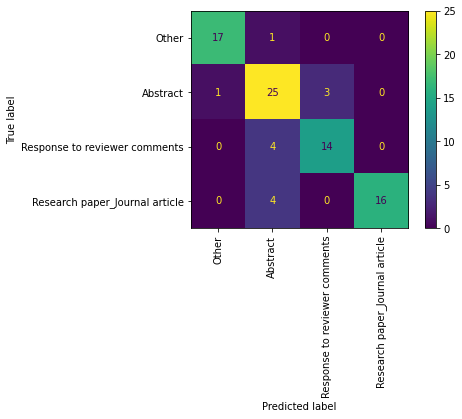

{'feature_vector_size': 901,
 'inference_time': 0.00023583804859834558,
 'vectorizing_time': 0.058342728895299574}

In [ ]:
def test_multilabel(y_true, y_pred):
  # labels = {}
  labels = {('non-rp', 'non-rtrc', 'abstract'): 'Abstract', 
    ('non-rp', 'non-rtrc', 'non-abstract'): 'Other', 
    ('non-rp', 'rtrc', 'non-abstract'): 'Response to reviewer comments', 
    ('rp', 'non-rtrc', 'non-abstract'): 'Research paper_Journal article'}
  labels_ = ["Abstract", "Other", "Response to reviewer comments", "Research paper_Journal article"]
  # for i,j in enumerate(np.unique(np.array(y_pred).astype("<U22"), axis = 0)):
  #   labels[tuple(j)] = labels_[i]
  y_pred_simple = []
  for i in np.array(y_pred):
    y_pred_simple.append(labels[tuple(i)])
  return y_pred_simple

def predict(rfc, tfidf_text, tfidf_headings, df, headings_text = False):
  X_text = tfidf_text.transform(df.text)
  if headings_text:
    X_headings = tfidf_headings.transform(df.heading_text)
    X_total = hstack([X_text,X_headings,df[["word_count2","n_tables","n_images"]].astype(float)])
  else:
    X_total = hstack([X_text,df[["word_count2","n_tables","n_images"]].astype(float)])
  y_true = df.doc_category
  y_pred = rfc.predict(X_total)
  return y_true, y_pred

def scorer_multilabel(rfc, X, y):
  y_pred = rfc.predict(X)
  y_true_simple = test_multilabel(y, y)
  y_pred_simple = test_multilabel(y, y_pred)
  cr_ = cr(y_true_simple, y_pred_simple, output_dict = True)
  res = {
      "accuracy":cr_["accuracy"],
      "rp_precision":cr_["Research paper_Journal article"]["precision"], 
      "rtrc_precision":cr_["Response to reviewer comments"]["precision"],
      "abstract_precision":cr_["Abstract"]["precision"],
      "rp_recall":cr_['Research paper_Journal article']["recall"],
      "weighted_f1_score":cr_['weighted avg']["f1-score"],
      "precision_weighted":cr_['weighted avg']['precision'],
      "recall_weighted":cr_['weighted avg']['recall']
  }
  return res

class_weights= [
                {"rp":1, "non-rp":0.1},
                {"rtrc":1, "non-rtrc":0.5},
                {"abstract":1, "non-abstract":0.5}
]
tfidf_bucket = TfidfVectorizer(tokenizer = tokenize, use_idf = True, norm = None, ngram_range = (1,2), min_df = 0.1111, max_df = 0.999)
X = tfidf_bucket.fit_transform(df_allcat_train_cv.text)
rfc_bucket = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 32, class_weight = class_weights)
rfc_bucket.fit(X, df_allcat_train_cv[["rp","rtrc","abstract"]])

print("*************Cross_Validation_Results**********")
pipe = Pipeline([("tfidf",tfidf_bucket), ("rfc", rfc_bucket)])
df_ = df.sample(frac=1).reset_index(drop = True) 
cv_result  = cross_validate(pipe, df_.text, df_[["rp","rtrc","abstract"]], cv = 5, scoring = scorer_multilabel)
print(pd.DataFrame(cv_result).mean(axis = 0))

print("\n\n*************Gold_Data_Test_Results************")

gold_res = {}
y_true_gold = full_gold.doc_category
t1 = time()
X_gold_bucket = tfidf_bucket.transform(full_gold.text).toarray()
t2 = time()
y_pred_gold = rfc_bucket.predict(X_gold_bucket)
y_pred_simple_gold = test_multilabel(y_true_gold, y_pred_gold)
t3 = time()
gold_res["vectorizing_time"] = (t2-t1)/X_gold_bucket.shape[0]
gold_res["inference_time"] = (t3-t2)/X_gold_bucket.shape[0]
gold_res["feature_vector_size"] = X_gold_bucket.shape[1]
print(cr(full_gold.doc_category, y_pred_simple_gold))
cmd(confusion_matrix=cm(y_true_gold,y_pred_simple_gold), display_labels=y_true_gold.unique()).plot(xticks_rotation='vertical')
plt.show()
gold_res
# #On Gold
# y_pred = rfc.predict(tfidf.transform(full_gold.text))
# y_true = full_gold.doc_category
# y_pred_simple_gold = test_multilabel(y_true, y_pred)

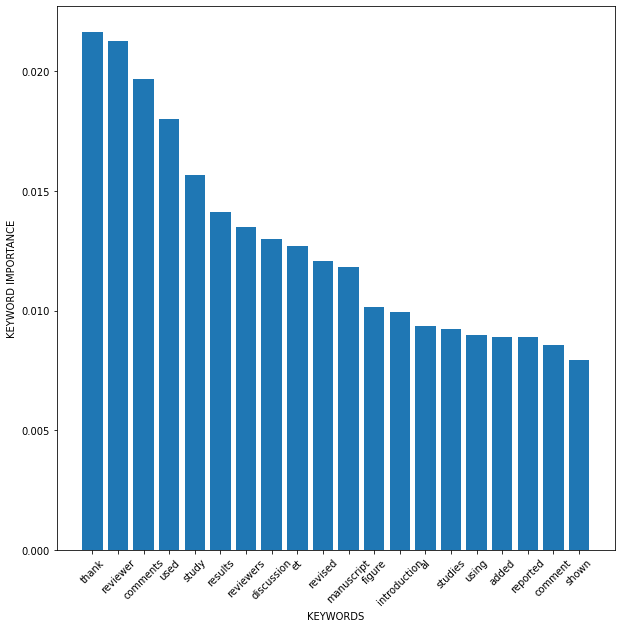

In [ ]:
plt.figure(figsize = (10,10))
plt.bar(x, y)
plt.xticks(rotation = 45)
plt.xlabel("KEYWORDS")
plt.ylabel("KEYWORD IMPORTANCE")
plt.show()

# Experiment 5(d): Pruning Multilabel(Failed)

In [ ]:
from tqdm import tqdm
def test_multilabel_prune(y_true, y_pred):
  labels = {}
  labels_ = ["Abstract", "Other", "Response to reviewer comments", "Research paper_Journal article"]
  for i,j in enumerate(np.unique(y_pred.astype("<U22"),axis = 0)):
    labels[tuple(j)] = labels_[i]
  y_pred_simple = []
  for i in y_pred.astype("<U22"):
    y_pred_simple.append(labels[tuple(i)])
  # print(cr(y_true,y_pred_simple))
  # print(cm(y_true,y_pred_simple))
  return np.array(y_pred_simple)
def create_classifier_signature(tree, df, rfc_, tfidf):
  '''
  x_test should be in vectorised form 
  '''
  x_test = tfidf.transform(list(df.text))
  classes = rfc_.classes_
  y_test = df.doc_category
  pred_tree_complex = tree.predict(x_test)
  pred_classes= test_multilabel_prune(y_test, pred_tree_complex)
  # dd  ={}
  # for k,v in enumerate(classes):
  #   dd[k] = v
  # pred_classes = [dd[i] for i in pred_tree]

  #Calculating Signature of a tree 
  signature = np.empty(pred_classes.shape)
  for i, j in enumerate(pred_classes):
    if j == y_test[i]:
      signature[i] = 1
    else:
      signature[i] = -1
  return signature

rf = rfc_bucket
tfidf_small = tfidf_bucket
rf_signature_list = []
for i in tqdm(range(len(rf.estimators_))):
  classifier_signature = create_classifier_signature(rf.estimators_[i], df_allcat_train, rf, tfidf_small)
  rf_signature_list.append(classifier_signature)
rf_signature_list = np.array(rf_signature_list)

100%|██████████| 130/130 [06:43<00:00,  3.11s/it]


In [ ]:
rf_signature_list.shape

(130, 2155)

In [ ]:
rf_signature_vector = np.average(rf_signature_list, axis = 0)
rf_signature_vector.shape

(2155,)

In [ ]:
# 'O' is like the ideal vector where the rf_signature vector should have pointed. 
def lambda_(x):
  o = np.ones(x.shape)
  l = (-o @ x) / (np.linalg.norm(x))**2
  return l

In [ ]:
#Calculating the reference vector 
alph = lambda_(rf_signature_vector)
rf_reference_vector = np.ones(rf_signature_vector.shape) + alph * rf_signature_vector
rf_reference_vector.shape

(2155,)

In [ ]:
dot  = rf_signature_list @ rf_reference_vector
orientations = dot / np.linalg.norm(rf_signature_list, axis = 1) / np.linalg.norm(rf_reference_vector)

In [ ]:
#Selecting thise DT's that are in first quadrant of rf_reference_vector and rf_signature_vector
final_ensemble = []
for i,j in enumerate(orientations):
  if j < 1.57 and j > 0:
    final_ensemble.append(rf.estimators_[i])

In [ ]:
def encode(y, rfc_):
  classes = rfc_.classes_
  dd = {"Abstract":(0,0,0),
      "Research paper_Journal article":(1,0,1),
      "Response to reviewer comments":(0,1,1),
      "Other":(0,0,1)}
  # for k,v in enumerate(classes):
  #   dd[tuple(v)] = k
  # print(dd)
  label = []
  for i,j in enumerate(y):
    label.append(np.array(dd[j]))
  return np.array(label)

In [ ]:
tree_to_label = {
    (0,0,0):(0,0,1,0),
    (0,0,1): (0,0,0,1),
    (0,1,1): (0,1,0,0),
    (1,0,1): (1,0,0,0)
}

index_to_label_dict = {
    0:'Research paper_Journal article',
    1:'Response to reviewer comments',
    2:'Abstract',
    3:'Other'
}

In [ ]:
df_allcat_train_cv.doc_category.unique()

array(['Abstract', 'Research paper_Journal article',
       'Response to reviewer comments', 'Other'], dtype=object)

In [ ]:
y1 = np.apply_along_axis(one_hot, 1,final_ensemble[0].predict(X))
y2 = np.apply_along_axis(one_hot, 1,final_ensemble[1].predict(X))

In [ ]:
y1 = y1.reshape((2425,1,4))
y2 = y2.reshape((2425,1,4))

In [ ]:
y1[0][0]

array([0, 0, 1, 0])

In [ ]:
y_comb = np.concatenate((y1,y2), axis = 1)

In [ ]:
y_voting = np.average(y_comb, axis = 1)

In [ ]:
y_voting_index = np.argmax(y_voting , axis = 1)

In [ ]:
def index_to_label(x):
  return index_to_label_dict[x[0]]

In [ ]:
y_voting_index = y_voting_index.reshape((1,2425))

In [ ]:
y_voting_index[0][0]

2

In [ ]:
np.apply_along_axis(index_to_label, 0, y_voting_index)

array(['Abstract', 'Research', 'Research', ..., 'Other', 'Response',
       'Other'], dtype='<U8')

In [ ]:
def one_hot(x):
  return tree_to_label[tuple(x)]

In [ ]:
ff = np.vectorize(tree_to_label[tuple(x)])

In [ ]:
np.apply_along_axis(one_hot, 1, y).T

(4, 2425)

In [ ]:
def voting(final_ensemble, X):
  n = X.shape[0]
  for i,tree in enumerate(final_ensemble):
    if (i == 0):
      y = np.apply_along_axis(one_hot, 1,tree.predict(X)).reshape((n,1,4))
    else:
      y_tree = np.apply_along_axis(one_hot, 1,tree.predict(X)).reshape((n,1,4))
      y = np.concatenate((y,y_tree), axis = 1)
  
  y_voting = np.average(y, axis = 1)
  y_voting_index = np.argmax(y_voting , axis = 1).reshape((1,n))
  pred_label = np.apply_along_axis(index_to_label, 0, y_voting_index)
  return pred_label

In [ ]:
X_test = tfidf_bucket.transform(full_gold.text)

In [ ]:
t1 = time()
pred_prune = voting(final_ensemble, X_test)
pred_prune_simple = [pruned_to_full_label[i] for i in pred_prune]
t2 = time()
print((t2-t1)/86)

0.0010507910750633062


In [ ]:
pruned_to_full_label = {
    "Resea":"Research paper_Journal article",
    "Respo": "Response to reviewer comments",
    "Abstr": "Abstract",
    "Other": "Other"
}

In [ ]:
print(cr(full_gold.doc_category, pred_prune_simple))

                                precision    recall  f1-score   support

                      Abstract       0.95      1.00      0.97        18
                         Other       0.91      0.69      0.78        29
Research paper_Journal article       0.68      0.94      0.79        18
 Response to reviewer comments       1.00      0.95      0.97        20

                      accuracy                           0.87        85
                     macro avg       0.88      0.90      0.88        85
                  weighted avg       0.89      0.87      0.87        85



In [ ]:
# #######################################
# #Some workaround
# import six
# import sys
# sys.modules['sklearn.externals.six'] = six

# #######################################
# from mlxtend.classifier import EnsembleVoteClassifier
# import copy
# eclf = EnsembleVoteClassifier(clfs=final_ensemble, weights=list(np.ones(len(final_ensemble))), refit=False)

# X_train_bucket = tfidf_bucket.transform(df_allcat_train.text)

y_train = encode(df_allcat_train.doc_category, rf) #This has to be encoded form or else it fails

eclf.fit(X_train_bucket,y_train)

#Putting the classes back in the eclf. this is imp since when you are pickeling, these classes names need to go along
eclf.classes_ = rf.classes_

NotImplementedError: ignored

In [ ]:
from tqdm import tqdm
def test_multilabel_prune(y_true, y_pred):
  labels = {}
  labels_ = ["Abstract", "Other", "Response to reviewer comments", "Research paper_Journal article"]
  for i,j in enumerate(np.unique(y_pred.astype("<U22"),axis = 0)):
    labels[tuple(j)] = labels_[i]
  y_pred_simple = []
  for i in y_pred:
    y_pred_simple.append(labels[tuple(i)])
  # print(cr(y_true,y_pred_simple))
  # print(cm(y_true,y_pred_simple))
  return y_pred_simple
def create_classifier_signature(tree, df, rfc_, tfidf):
  '''
  x_test should be in vectorised form 
  '''
  x_test = tfidf.transform(list(df.text))
  classes = rfc_.classes_
  y_test = df.doc_category
  pred_tree_complex = tree.predict(x_test)
  pred_tree = test_multilabel(y_test, pred_tree_complex)
  dd  ={}
  for k,v in enumerate(classes):
    dd[k] = v
  pred_classes = [dd[i] for i in pred_tree]

  #Calculating Signature of a tree 
  signature = np.empty(pred_tree.shape)
  for i, j in enumerate(pred_classes):
    if j == y_test[i]:
      signature[i] = 1
    else:
      signature[i] = -1
  return signature

rf = rfc_bucket
tfidf_small = tfidf_bucket
rf_signature_list = []
for i in tqdm(range(len(rf.estimators_))):
  classifier_signature = create_classifier_signature(rf.estimators_[i], df_allcat_train, rf, tfidf_small)
  rf_signature_list.append(classifier_signature)
rf_signature_list = np.array(rf_signature_list)

rf_signature_vector = np.average(rf_signature_list, axis = 0)
rf_signature_vector.shape

# 'O' is like the ideal vector where the rf_signature vector should have pointed. 
def lambda_(x):
  o = np.ones(x.shape)
  l = (-o @ x) / (np.linalg.norm(x))**2
  return l

#Calculating the reference vector 
alph = lambda_(rf_signature_vector)
rf_reference_vector = np.ones(rf_signature_vector.shape) + alph * rf_signature_vector
rf_reference_vector.shape

dot  = rf_signature_list @ rf_reference_vector
orientations = dot / np.linalg.norm(rf_signature_list, axis = 1) / np.linalg.norm(rf_reference_vector)

#Selecting those DT's that are in first quadrant of rf_reference_vector and rf_signature_vector
final_ensemble = []
for i,j in enumerate(orientations):
  if j < 1.57 and j > 0:
    final_ensemble.append(rf.estimators_[i])

def encode(y, rfc_):
  classes = rfc_.classes_
  dd = {}
  for k,v in enumerate(classes):
    dd[v] = k
  label = np.empty(y.shape)
  for i,j in enumerate(y):
    label[i] = dd[j]
  return label

  0%|          | 0/1000 [00:06<?, ?it/s]


KeyError: ignored

# Experiment 6(a): One-against-all

In [ ]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def tokenize(text):
    '''
    It takes text, removes stopwords and returns list of stemmed tokens
    '''
    word_tokens = nltk.word_tokenize(text)
    #Removing stopwords
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    stems = []
    for item in filtered_sentence:
        stems.append(PorterStemmer().stem(item))
    return stems

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
tfidf_rp = TfidfVectorizer(use_idf = True, stop_words = "english", min_df = 0.111, max_df = 0.999)
rfc_rp = RandomForestClassifier(n_estimators = 200, criterion = "entropy", random_state = 32, n_jobs = -1, max_depth = 25)
X = tfidf_rp.fit_transform(df_allcat_train_cv.text)
df_x = pd.DataFrame(X.toarray())
df_x.columns = tfidf_rp.get_feature_names_out()
rfc_rp.fit(X, df_allcat_train_cv.rp)

RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=200,
                       n_jobs=-1, random_state=32)

In [ ]:
print(cr(full_gold.rp,rfc_rp.predict(tfidf_rp.transform(full_gold.text))))
print(cm(full_gold.rp,rfc_rp.predict(tfidf_rp.transform(full_gold.text))))

print(cr(new_gold.sam_rp,rfc_rp.predict(tfidf_rp.transform(new_gold.text))))
print(cm(new_gold.sam_rp,rfc_rp.predict(tfidf_rp.transform(new_gold.text))))

              precision    recall  f1-score   support

      non-rp       0.93      0.94      0.93        67
          rp       0.76      0.72      0.74        18

    accuracy                           0.89        85
   macro avg       0.85      0.83      0.84        85
weighted avg       0.89      0.89      0.89        85

[[63  4]
 [ 5 13]]
              precision    recall  f1-score   support

      non-rp       0.67      0.98      0.80        52
          rp       0.96      0.47      0.63        47

    accuracy                           0.74        99
   macro avg       0.81      0.72      0.71        99
weighted avg       0.81      0.74      0.72        99

[[51  1]
 [25 22]]


In [ ]:
df_allcat_train_cv.head()

,index,doc_name,doc_category,domain,status,word_count,n_tables,n_paragraphs,n_images,n_headings,heading_text,text,raw_category,rtrc,abstract,rp,word_count2
0,216,KYOBO_726_input.json,Abstract,Physical Sciences,Original,539,0,6,0,3,(S-21-0122) (S-21-0123) (S-21-0126),s an experimental research on operation chara...,Abstract,0,1,0,535
1,1898,ELSVR_68003_input.json,Research paper_Journal article,Physical Sciences,Original,5856,0,83,34,4,1. Introduction 3. Failure of specimens 4. Tem...,experimental study on mechanical behavior of s...,Research paper_Journal article,0,0,1,5973
2,2108,ELSVR_71326_input.json,Research paper_Journal article,Humanities,Original,35201,0,122,18,10,Introduction Existing Literature Hypotheses 4....,introduction the board of directors plays an e...,Research paper_Journal article,0,0,1,14010
3,322,UNCGS_20_input.json,Abstract,Humanities,Original,97,0,1,0,0,,parliamentary control over budgets is a fundam...,Abstract,0,1,0,103
4,1657,HYUGC_20_input.json,Response to reviewer comments,Medicine,Original,500,0,15,0,0,,reviewer i think data and methods should be ...,Response to reviewer comments,1,0,0,573


In [ ]:
#For Headings

tfidf_rp = TfidfVectorizer(use_idf = True, stop_words = "english", min_df = 0.111, max_df = 0.999)
rfc_rp = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 32, n_jobs = -1)
X = tfidf_rp.fit_transform(df_allcat_train_cv.heading_text)
df_x = pd.DataFrame(X.toarray())
df_x.columns = tfidf_rp.get_feature_names_out()
rfc_rp.fit(X, df_allcat_train_cv.rp)

print(cr(full_gold.rp,rfc_rp.predict(tfidf_rp.transform(full_gold.heading_text))))
print(cm(full_gold.rp,rfc_rp.predict(tfidf_rp.transform(full_gold.heading_text))))

print(cr(new_gold.sam_rp,rfc_rp.predict(tfidf_rp.transform(new_gold.heading_text))))
print(cm(new_gold.sam_rp,rfc_rp.predict(tfidf_rp.transform(new_gold.heading_text))))

              precision    recall  f1-score   support

      non-rp       0.88      0.94      0.91        67
          rp       0.69      0.50      0.58        18

    accuracy                           0.85        85
   macro avg       0.78      0.72      0.74        85
weighted avg       0.84      0.85      0.84        85

[[63  4]
 [ 9  9]]
              precision    recall  f1-score   support

      non-rp       0.72      0.94      0.82        52
          rp       0.90      0.60      0.72        47

    accuracy                           0.78        99
   macro avg       0.81      0.77      0.77        99
weighted avg       0.81      0.78      0.77        99

[[49  3]
 [19 28]]


In [ ]:
def predict_nested(tfidf_rtrc, tfidf_abstract, tfidf_rp, rfc_abstract, rfc_rtrc, rfc_rp, text, heading_text):
  '''
  Takes all three random forests and their vectoriser and returns the final prediction.
  '''
  combined = [text]
  t1 = time()
  x_rtrc = tfidf_rtrc.transform(combined)
  t2 = time()
  rtrc_pred = rfc_rtrc.predict(x_rtrc)
  t3 = time()
  inf = t3-t2
  vect = t2-t1
  if rtrc_pred == "rtrc":
    return {"class":'Response to reviewer comments', "prob" : rfc_rtrc.predict_proba(x_rtrc), "inf_time":t3-t2, "vect_time":t2-t1}
  else:
    t1 = time()
    x_abstract = tfidf_abstract.transform(combined)
    t2 = time()
    abstract_pred = rfc_abstract.predict(x_abstract)
    t3 = time()
    vect = vect+t2-t1
    inf = inf+t3-t2
    if abstract_pred == "abstract":
      return {"class":'Abstract', "prob" : rfc_abstract.predict_proba(x_abstract), "inf_time":inf, "vect_time":vect}
    else:
      t1 = time()
      x_rp = tfidf_rp.transform([heading_text])
      t2 = time()
      rp_pred = rfc_rp.predict(x_rp)
      t3 = time()
      vect = vect+t2-t1
      inf = inf+t3-t2
      if rp_pred == "rp":
        return {"class":'Research paper_Journal article', "prob" : rfc_rp.predict_proba(x_rp), "inf_time":inf, "vect_time":vect}
      else:
        return {"class":'Other', "prob" : "NULL", "inf_time":inf, "vect_time":vect}

In [ ]:
def scorer_one_against_all(y, y_pred):
  # y_pred = rfc.classes_[rfc.predict(X).astype(int)]
  cr_ = cr(y, y_pred, output_dict = True)
  res = {
      "accuracy":cr_["accuracy"],
      "rp_precision":cr_["Research paper_Journal article"]["precision"], 
      "rtrc_precision":cr_["Response to reviewer comments"]["precision"],
      "abstract_precision":cr_["Abstract"]["precision"],
      "rp_recall":cr_['Research paper_Journal article']["recall"],
      "weighted_f1_score":cr_['weighted avg']["f1-score"],
      "precision_weighted":cr_['weighted avg']['precision'],
      "recall_weighted":cr_['weighted avg']['recall']
  }
  return res

In [ ]:
#Five fold Cross Validation for Nested one-against-all Models
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
fold = 1
results = []
df = df.sample(frac = 1).reset_index(drop = True)
for train_index, test_index in kf.split(df):
  print("-"*100)
  print(f"\nTraining for fold: {fold}")
  df_temp_train = df.iloc[train_index,:].reset_index(drop = True)
  df_temp_test = df.iloc[test_index,:].reset_index(drop = True)
  fold+=1
  tfidf_rp = TfidfVectorizer(use_idf = True, stop_words = "english")
  rfc_rp = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 32, n_jobs = -1)
  X = tfidf_rp.fit_transform(df_temp_train.heading_text)
  rfc_rp.fit(X, df_temp_train.rp)

  tfidf_rtrc = TfidfVectorizer(stop_words = "english", use_idf = True, min_df = 0.1111, max_df = 0.9999)
  rfc_rtrc = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 32, n_jobs = -1)
  X = tfidf_rtrc.fit_transform(df_temp_train.text)
  rfc_rtrc.fit(X, df_temp_train.rtrc)

  tfidf_abstract = tfidf_rtrc # TfidfVectorizer(stop_words = "english", use_idf = True, min_df = 0.1111, max_df = 0.9999)
  rfc_abstract = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 32, n_jobs = -1)
  X = tfidf_abstract.fit_transform(df_temp_train.text)
  rfc_abstract.fit(X, df_temp_train.abstract)

  param = {"tfidf_rtrc": tfidf_rtrc, 
          "tfidf_abstract": tfidf_abstract, 
          "tfidf_rp": tfidf_rp,
          "rfc_abstract": rfc_abstract, 
          "rfc_rtrc": rfc_rtrc, 
          "rfc_rp": rfc_rp, 
          "text": "", 
          "heading_text": ""}
          
  y_pred = []
  for doc in tqdm(df_temp_test.doc_name):
    text_ = df_temp_test.loc[df_temp_test.doc_name == doc].text
    text = text_.values[0][:]
    text_ = df_temp_test.loc[df_temp_test.doc_name == doc].heading_text
    heading_text = text_.values[0][:]
    param["text"] = text
    param["heading_text"] = heading_text
    y_pred.append(predict_nested(**param)["class"])
  print("\nInference Done. Calculating statistics...")
  res = scorer_one_against_all(df_temp_test.doc_category, y_pred)
  results.append(res)
  print(res)

In [ ]:
#Five fold Cross Validation for Nested one-against-all Models
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
fold = 1
results = []
df = df.sample(frac = 1).reset_index(drop = True)
for train_index, test_index in kf.split(df):
  print("-"*100)
  print(f"\nTraining for fold: {fold}")
  df_temp_train = df.iloc[train_index,:].reset_index(drop = True)
  df_temp_test = df.iloc[test_index,:].reset_index(drop = True)
  fold+=1
  tfidf_rp = TfidfVectorizer(use_idf = True, stop_words = "english")
  rfc_rp = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 32, n_jobs = -1)
  X = tfidf_rp.fit_transform(df_temp_train.heading_text)
  rfc_rp.fit(X, df_temp_train.rp)

  tfidf_rtrc = TfidfVectorizer(stop_words = "english", use_idf = True, min_df = 0.1111, max_df = 0.9999)
  rfc_rtrc = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 32, n_jobs = -1)
  X = tfidf_rtrc.fit_transform(df_temp_train.text)
  rfc_rtrc.fit(X, df_temp_train.rtrc)

  tfidf_abstract = tfidf_rtrc # TfidfVectorizer(stop_words = "english", use_idf = True, min_df = 0.1111, max_df = 0.9999)
  rfc_abstract = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 32, n_jobs = -1)
  X = tfidf_abstract.fit_transform(df_temp_train.text)
  rfc_abstract.fit(X, df_temp_train.abstract)

  param = {"tfidf_rtrc": tfidf_rtrc, 
          "tfidf_abstract": tfidf_abstract, 
          "tfidf_rp": tfidf_rp,
          "rfc_abstract": rfc_abstract, 
          "rfc_rtrc": rfc_rtrc, 
          "rfc_rp": rfc_rp, 
          "text": "", 
          "heading_text": ""}

  y_pred = []
  for doc in tqdm(df_temp_test.doc_name):
    text_ = df_temp_test.loc[df_temp_test.doc_name == doc].text
    text = text_.values[0][:]
    text_ = df_temp_test.loc[df_temp_test.doc_name == doc].heading_text
    heading_text = text_.values[0][:]
    param["text"] = text
    param["heading_text"] = heading_text
    y_pred.append(predict_nested(**param)["class"])
  print("\nInference Done. Calculating statistics...")
  res = scorer_one_against_all(df_temp_test.doc_category, y_pred)
  results.append(res)

----------------------------------------------------------------------------------------------------

Training for fold: 1


100%|██████████| 539/539 [02:56<00:00,  3.05it/s]



Inference Done. Calculating statistics...
----------------------------------------------------------------------------------------------------

Training for fold: 2


100%|██████████| 539/539 [02:57<00:00,  3.04it/s]



Inference Done. Calculating statistics...
----------------------------------------------------------------------------------------------------

Training for fold: 3


100%|██████████| 539/539 [02:57<00:00,  3.03it/s]



Inference Done. Calculating statistics...
----------------------------------------------------------------------------------------------------

Training for fold: 4


100%|██████████| 539/539 [02:57<00:00,  3.04it/s]



Inference Done. Calculating statistics...
----------------------------------------------------------------------------------------------------

Training for fold: 5


100%|██████████| 539/539 [02:55<00:00,  3.07it/s]


Inference Done. Calculating statistics...


In [ ]:
#Taking average of all 5 fold metrics
pd.DataFrame(results).mean(axis = 0)

accuracy              0.699814
rp_precision          0.675653
rtrc_precision        0.940166
abstract_precision    0.835453
rp_recall             0.696010
weighted_f1_score     0.706898
precision_weighted    0.734007
recall_weighted       0.699814
dtype: float64

In [ ]:
#Testing on Gold
y_pred = []
inf = []
vect = []
for doc in tqdm(full_gold.doc_name):
  text_ = full_gold.loc[full_gold.doc_name == doc].text
  text = text_.values[0][:]
  text_ = full_gold.loc[full_gold.doc_name == doc].heading_text
  heading_text = text_.values[0][:]
  param["text"] = text
  param["heading_text"] = heading_text
  pred = predict_nested(**param)
  y_pred.append(pred["class"])
  inf.append(pred["inf_time"])
  vect.append(pred["vect_time"])

100%|██████████| 85/85 [00:26<00:00,  3.15it/s]


In [ ]:
print(cr(full_gold.doc_category, y_pred))
print(cm(full_gold.doc_category, y_pred))

                                precision    recall  f1-score   support

                      Abstract       1.00      0.89      0.94        18
                         Other       0.69      0.76      0.72        29
Research paper_Journal article       0.65      0.61      0.63        18
 Response to reviewer comments       0.95      0.95      0.95        20

                      accuracy                           0.80        85
                     macro avg       0.82      0.80      0.81        85
                  weighted avg       0.81      0.80      0.80        85

[[16  2  0  0]
 [ 0 22  6  1]
 [ 0  7 11  0]
 [ 0  1  0 19]]


In [ ]:
print(f'Inference time: {sum(inf)/len(inf)}')
print(f'Vectorisation time: {sum(vect)/len(vect)}')

Inference time: 0.2413960989783792
Vectorisation time: 0.007316743626314051


# Experiment 6(b): One against all (using body text only)

In [ ]:
#Five fold Cross Validation for Nested one-against-all Models
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
fold = 1
results = []
df = df.sample(frac = 1).reset_index(drop = True)
for train_index, test_index in kf.split(df):
  print("-"*100)
  print(f"\nTraining for fold: {fold}")
  df_temp_train = df.iloc[train_index,:].reset_index(drop = True)
  df_temp_test = df.iloc[test_index,:].reset_index(drop = True)
  fold+=1
  tfidf_rp = TfidfVectorizer(use_idf = True, stop_words = "english")
  rfc_rp = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 32, n_jobs = -1)
  X = tfidf_rp.fit_transform(df_temp_train.text)
  rfc_rp.fit(X, df_temp_train.rp)

  tfidf_rtrc = TfidfVectorizer(stop_words = "english", use_idf = True, min_df = 0.1111, max_df = 0.9999)
  rfc_rtrc = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 32, n_jobs = -1)
  X = tfidf_rtrc.fit_transform(df_temp_train.text)
  rfc_rtrc.fit(X, df_temp_train.rtrc)

  tfidf_abstract = tfidf_rtrc # TfidfVectorizer(stop_words = "english", use_idf = True, min_df = 0.1111, max_df = 0.9999)
  rfc_abstract = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 32, n_jobs = -1)
  X = tfidf_abstract.fit_transform(df_temp_train.text)
  rfc_abstract.fit(X, df_temp_train.abstract)

  param = {"tfidf_rtrc": tfidf_rtrc, 
          "tfidf_abstract": tfidf_abstract, 
          "tfidf_rp": tfidf_rp,
          "rfc_abstract": rfc_abstract, 
          "rfc_rtrc": rfc_rtrc, 
          "rfc_rp": rfc_rp, 
          "text": "", 
          "heading_text": ""}
          
  y_pred = []
  for doc in tqdm(df_temp_test.doc_name):
    text_ = df_temp_test.loc[df_temp_test.doc_name == doc].text
    text = text_.values[0][:]
    text_ = df_temp_test.loc[df_temp_test.doc_name == doc].heading_text
    heading_text = text_.values[0][:]
    param["text"] = text
    param["heading_text"] = text
    y_pred.append(predict_nested(**param)["class"])
  print("\nInference Done. Calculating statistics...")
  res = scorer_one_against_all(df_temp_test.doc_category, y_pred)
  results.append(res)

----------------------------------------------------------------------------------------------------

Training for fold: 1


100%|██████████| 539/539 [02:59<00:00,  3.00it/s]



Inference Done. Calculating statistics...
----------------------------------------------------------------------------------------------------

Training for fold: 2


100%|██████████| 539/539 [02:57<00:00,  3.03it/s]



Inference Done. Calculating statistics...
----------------------------------------------------------------------------------------------------

Training for fold: 3


100%|██████████| 539/539 [02:57<00:00,  3.03it/s]



Inference Done. Calculating statistics...
----------------------------------------------------------------------------------------------------

Training for fold: 4


100%|██████████| 539/539 [02:56<00:00,  3.05it/s]



Inference Done. Calculating statistics...
----------------------------------------------------------------------------------------------------

Training for fold: 5


100%|██████████| 539/539 [02:56<00:00,  3.05it/s]


Inference Done. Calculating statistics...


In [ ]:
pd.DataFrame(results).mean(axis = 0)

accuracy              0.667161
rp_precision          0.708319
rtrc_precision        0.937848
abstract_precision    0.837613
rp_recall             0.502187
weighted_f1_score     0.674283
precision_weighted    0.725192
recall_weighted       0.667161
dtype: float64

In [ ]:
y_pred = []
inf = []
vect = []
for doc in tqdm(full_gold.doc_name):
  text_ = full_gold.loc[full_gold.doc_name == doc].text
  text = text_.values[0][:]
  text_ = full_gold.loc[full_gold.doc_name == doc].heading_text
  heading_text = text_.values[0][:]
  param["text"] = text
  param["heading_text"] = text
  pred = predict_nested(**param)
  y_pred.append(pred["class"])
  inf.append(pred["inf_time"])
  vect.append(pred["vect_time"])

100%|██████████| 85/85 [00:27<00:00,  3.07it/s]


In [ ]:
print(cr(full_gold.doc_category, y_pred))
print(cm(full_gold.doc_category, y_pred))

                                precision    recall  f1-score   support

                      Abstract       0.94      0.83      0.88        18
                         Other       0.77      0.79      0.78        29
Research paper_Journal article       0.82      0.78      0.80        18
 Response to reviewer comments       0.91      1.00      0.95        20

                      accuracy                           0.85        85
                     macro avg       0.86      0.85      0.85        85
                  weighted avg       0.85      0.85      0.85        85

[[15  3  0  0]
 [ 1 23  3  2]
 [ 0  4 14  0]
 [ 0  0  0 20]]


In [ ]:
print(f'Inference time: {sum(inf)/len(inf)}')
print(f'Vectorisation time: {sum(vect)/len(vect)}')

Inference time: 0.2409711613374598
Vectorisation time: 0.012030076980590821
